In [1]:
# @title import
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import math
import matplotlib as mpl
import matplotlib.font_manager as fm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from IPython.display import Latex

import gcsfs
from dfply import *
from IPython.core.display import display, HTML
from IPython.display import Image as jp_image # mnist도 image라서 이름 바꿈
display(HTML("<style>.container { width:85% !important; }</style>"))

import os
import sys
import pickle

In [2]:
print(os.getcwd())

/Volumes/GoogleDrive/공유 드라이브/Predictive Marketing/Team/개인/항민/deep_learning_from_the_basic


In [3]:
#mac
path = "/Volumes/GoogleDrive/공유 드라이브/Predictive Marketing/Team/개인/항민/deep_learning_from_the_basic/other/deep_learning_images/"
#windows
# path = "D:\공유 드라이브\Predictive Marketing\Team\개인\항민\deep_learning_from_the_basic\other\deep_learning_images/"

In [4]:
print(path)

/Volumes/GoogleDrive/공유 드라이브/Predictive Marketing/Team/개인/항민/deep_learning_from_the_basic/other/deep_learning_images/


In [6]:
# def fig(img_name, img_type = ".png", w = 200, h = 200):
#   img_name = str(img_name)+str(img_type)
#   return Image(path+img_name, width = w, height = h)

In [5]:
def fig(img_name, img_type = ".png", w = 200, h = 200):
  img_name = str(img_name)+str(img_type)
  return jp_image(path+img_name, width = w, height = h)

# Ch.5 오차역전파법

앞 장에서는 신경망 학습에 대해 공부함. 신경망의 가중치 매개변수 기울기(= 가중치 매개변수에 대한 손실 함수의  기울기)는 수치 미분을 사용해 구했는데,

수치 미분은 단순하고 구현하기도 쉽지만 계산 시간이 오래 걸리는 단점이 존재함.

이번 장에서는 가중치 매개변수의 기울기를 효율적으로 계싼하는 '오차 역전파법'을 배워본다.(수식보다는 기하학적으로)


## 계산 그래프

계산 그래프는 계산 과정을 그래프로 나타낸 것. 복수의 노드와 엣지로 표현됨(엣지 = 노드 사이의 직선)

### 계산 그래프로 풀다

문제 1: 현빈 군은 슈퍼에서 1개에 100원인 사과를 2개 샀습니다. 이 때의 지불 금액을 구하세요. 단, 소비세가 10% 부과됩니다.
계산 과정 자체는 쉽지만, 계산그래프로 이 계산식을 표현하면 아래와 같다.
사과의 100원이 *2 노드로 흐르고, 200원이 되어 다시 *1.1 노드를 거쳐 220원이 출력


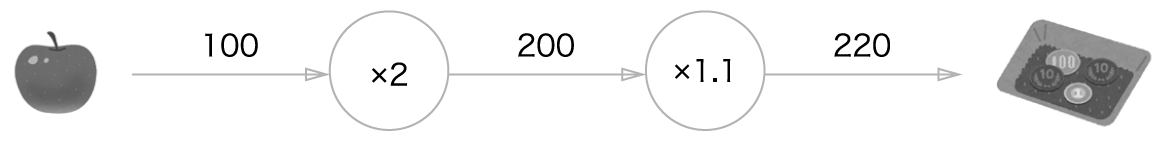

In [6]:
print("문제 1: 현빈 군은 슈퍼에서 1개에 100원인 사과를 2개 샀습니다. 이 때의 지불 금액을 구하세요. 단, 소비세가 10% 부과됩니다.\n"
     "계산 과정 자체는 쉽지만, 계산그래프로 이 계산식을 표현하면 아래와 같다.\n"
     "사과의 100원이 *2 노드로 흐르고, 200원이 되어 다시 *1.1 노드를 거쳐 220원이 출력")
fig("fig 5-1", w = 500)

문제 1에서 사과의 갯수와 소비세를 변수로 취급해 원 밖에 표현할 수도 있음


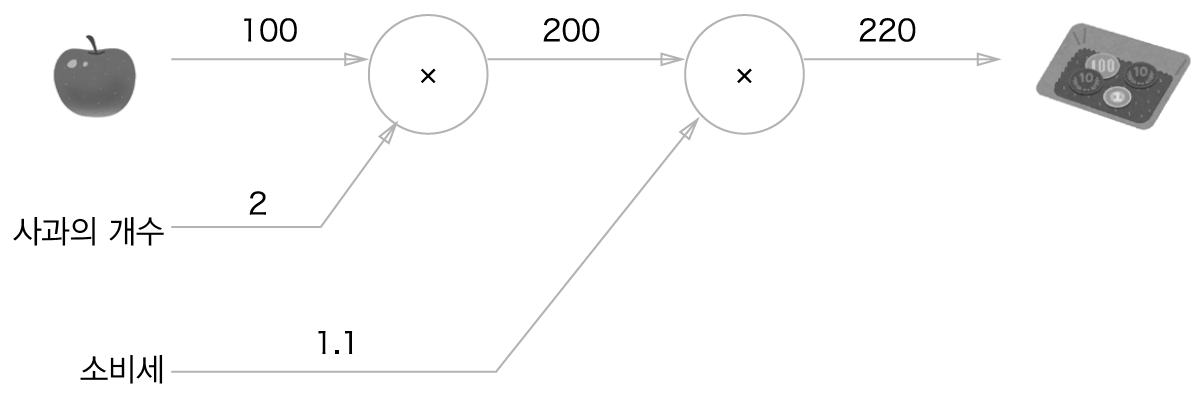

In [12]:
print("문제 1에서 사과의 갯수와 소비세를 변수로 취급해 원 밖에 표현할 수도 있음")
fig("fig 5-2", w = 500)

문제 2: 현빈 군은 슈퍼에서 사과를 2개, 귤을 3개 샀습니다. 사과는 1개에 100원, 귤은 1개 150원이며, 소비세는 10%입니다.
지불 금액은?
사과의 100원이 *2 노드로 흐르고, 200원이 되어 다시 *1.1 노드를 거쳐 220원이 출력


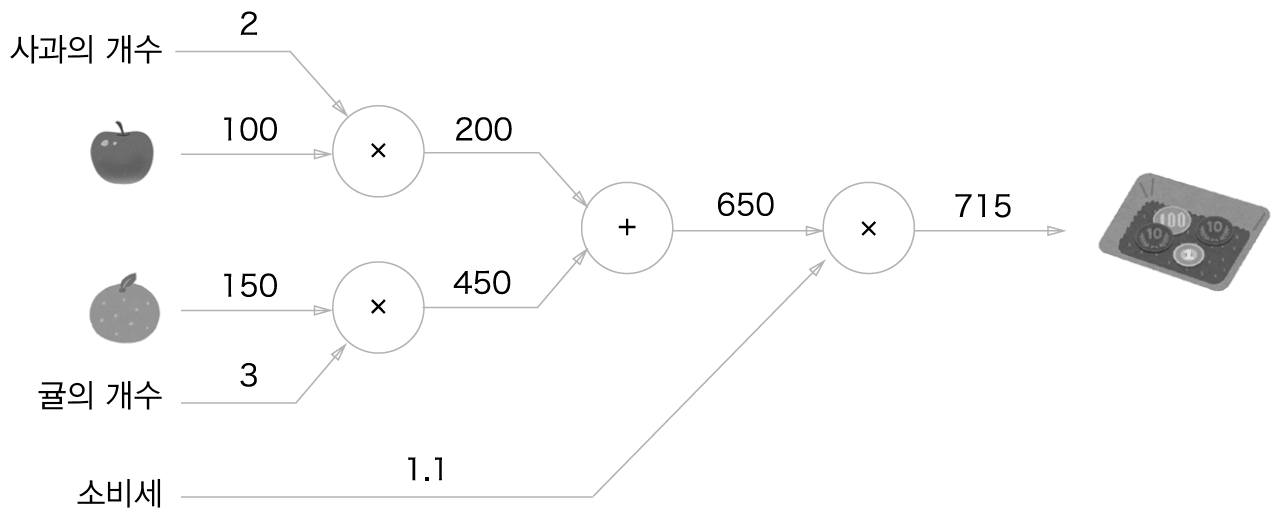

In [13]:
print("문제 2: 현빈 군은 슈퍼에서 사과를 2개, 귤을 3개 샀습니다. 사과는 1개에 100원, 귤은 1개 150원이며, 소비세는 10%입니다.\n"
      "지불 금액은?\n"
     "사과의 100원이 *2 노드로 흐르고, 200원이 되어 다시 *1.1 노드를 거쳐 220원이 출력")
fig("fig 5-3", w = 500)

1. 계산 그래프를 구성한다.
2. 그래프에서 계산을 왼쪽에서 오른쪽으로 진행한다. == 순전파

오른족에서 왼쪽으로 진행하는 것을 역전파



### 국소적 계산

계산 그래프의 특징은 '국소적 계산'을 전파함으로써 최종 결과를 얻는다.
국소적이란 '자신과 직접 관계된 작은 범위'라는 뜻이며, 결국 전체에서 어떤 일이 벌어지든 자신과 관계된 정보만으로 겨로가를 출력
e.g. 슈퍼마켓에서 사과 2개를 포함한 여러 식품을 구매하는 경우는 아래와 같다.
이 예시에서의 핵심은 노드에서 계산이 발생할 때 다른 식품의 계산은 신경 쓸 필요가 없고, 자신(==사과)의 계산만 신경쓰면 된다는 것
--> 국소적 계산(분업)에 집중


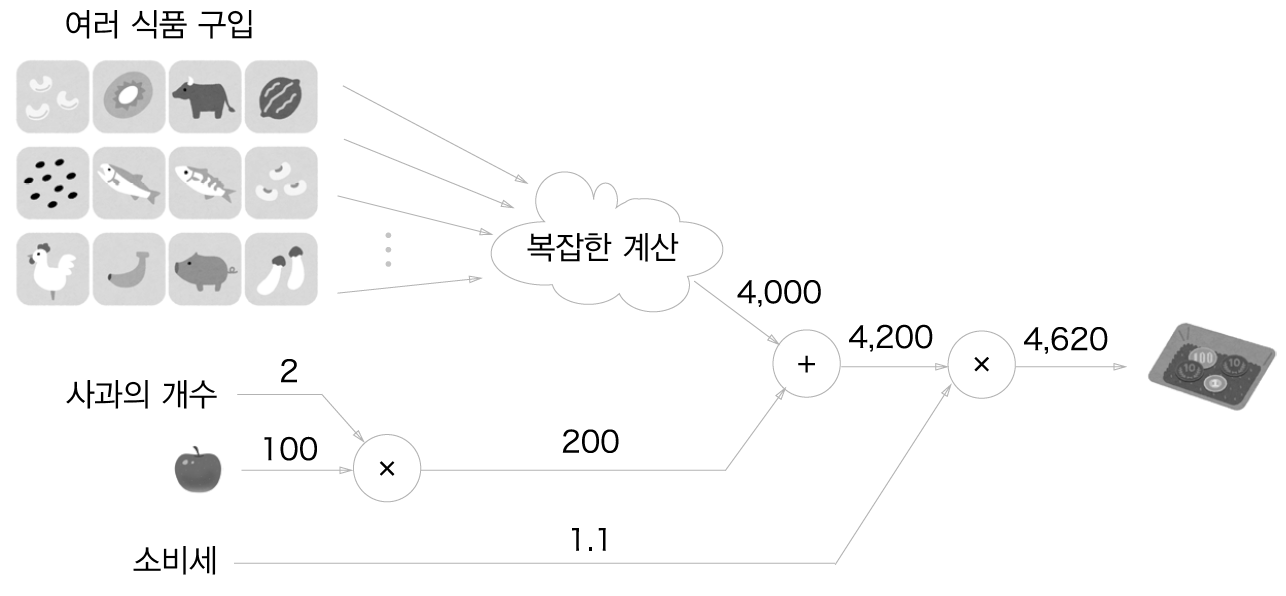

In [17]:
print("계산 그래프의 특징은 '국소적 계산'을 전파함으로써 최종 결과를 얻는다.\n"
     "국소적이란 '자신과 직접 관계된 작은 범위'라는 뜻이며, 결국 전체에서 어떤 일이 벌어지든 자신과 관계된 정보만으로 겨로가를 출력\n"
     "e.g. 슈퍼마켓에서 사과 2개를 포함한 여러 식품을 구매하는 경우는 아래와 같다.\n"
     "이 예시에서의 핵심은 노드에서 계산이 발생할 때 다른 식품의 계산은 신경 쓸 필요가 없고, 자신(==사과)의 계산만 신경쓰면 된다는 것\n"
     "--> 국소적 계산(분업)에 집중")
fig("fig 5-4", w = 500)

### 왜 계산 그래프로 푸는가?

계산 그래프의 

첫 번째 이점은 바로 '국소적 계산' - 전체가 아무리 복잡해도 노드만 잘 구성된다면 단순한 계산에 집중하여 문제 자체를 단순화할 수 있다.

두 번째 이점은 중간 계산 결과를 보관할 수 있다는 점임.(사과 2개의 가격 계산까지는 200원, 부가세 1.1 곱해지면 220원 등)

세 번째 이점은 역전파를 통해 '미분'을 효율적으로 계산할 수 있는 점이다.

In [73]:
print("계산 그래프의 역전파 - 사과 가격에 변화가 있을 경우 최종 금액에 어떤 영향을 끼치는 지 알고 싶을 때?\n"
     " 이는 '사과 가격에 대한 지불 금액의 미분(f(dx)는 f(x)의 몇배?)'를 구하는 문제")

계산 그래프의 역전파 - 사과 가격에 변화가 있을 경우 최종 금액에 어떤 영향을 끼치는 지 알고 싶을 때?
 이는 '사과 가격에 대한 지불 금액의 미분(f(dx)는 f(x)의 몇배?)'를 구하는 문제


In [7]:
Latex("사과의 가격을 $x$, 지불 금액을 $L$이라 했을 때, $\cfrac{\partial{L}}{\partial{x}}$을 구하는 것이며, 사과 값이 일정량 변했을 때 전체 지불 금액은 얼마나 변하는 지를 나타냄")

<IPython.core.display.Latex object>

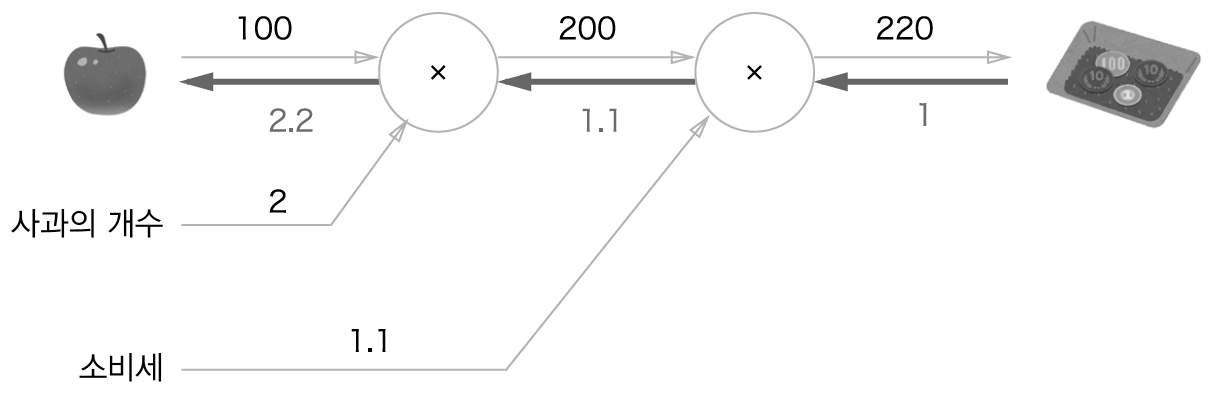

In [74]:
fig("fig 5-5", w = 500)

사과 가격이 1원 오르면 최종 가격은 2.2원 오른다(== 사과 가격 1원이 변하면 최종 금액은 그 것의 2.2배만큼 변화한다.)

편미분이기 때문에 사과 가격에 대한 변화뿐만 아니라 소비세, 사과 개수에 대한 미분도 가능함

## 연쇄 법칙

역전파는 '국소적인 미분'을 순방향과는 반대인 오른쪽에서 왼쪽으로 전달하는 것인데, 이는 '연쇄법칙(chain rule)'에 따른 것이며

이는 계산 그래프 상의 역전파와 같다.

### 계산 그래프의 역전파

In [84]:
Latex("$y = f(x)$라는 함수의 역전파는 아래와 같음")
# Latex("$사과의 가격을 x, 지불 금액을 L이라 했을 때, \cfrac{\partial{L}}{\partial{x}}$을 구하는 것이며, 사과 값이 일정량 변했을 때 전체 지불 금액은 얼마나 변하는 지를 나타냄")


<IPython.core.display.Latex object>

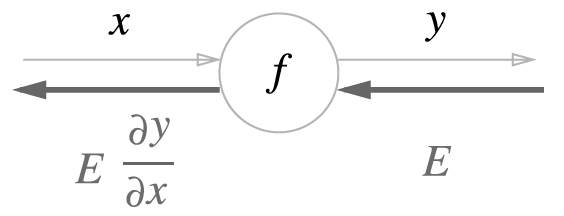

In [83]:
fig("fig 5-6", w = 500)

위 식처럼 역전파의 계산 절차는 신호 $E$에 노드의 국소적 미분 $(\cfrac{\partial{y}}{\partial{x}})$을 곱한 후 다음 노드로 전달하는 것

여기서 말하는 국소적 미분은 순전파 때의 $y = f(x)$ 함수의 미분을 구하는 것이며, 이는 $x$에 대한 $y$의 미분 $(\cfrac{\partial{y}}{\partial{x}})$을 구한다는 뜻이다.

가령 $y = f(x) = x^2$라면, $(\cfrac{\partial{y}}{\partial{x}}) = 2x$가 된다. 

그리고 이 국소적인 미분을 상위 노드에서 전달된 값(여기서는 $E$)에 곱해서 하위 노드로 전달하는 것

### 연쇄 법칙이란?

연쇄법칙을 설명하려면 우선 합성 함수 이야기부터 시작해야하는데, 

합성 함수란 여러 함수로 구성된 함수를 말한다. 예를 들어 $z = (x + y)^2$라는 식은 식 5.1처럼 두 개의 식으로 구성된다.

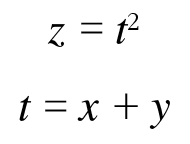

In [93]:
fig("e 5.1", w = 250)

연쇄 법칙은 합성 함수의 미분에 대한 성질이며, 다음과 같이 정의된다.

'합성 함수의 미분은 합성 함수를 구성하는 각 함수의 미분의 곱으로 나타낼 수 있다.'

위의 식 5.1을 예로 들면,

$(\cfrac{\partial{z}}{\partial{x}})$ ($x$에 대한 $z$의 미분)은 $(\cfrac{\partial{z}}{\partial{t}})$ ($t$에 대한 $z$의 미분)과 $(\cfrac{\partial{t}}{\partial{x}})$ ($x$에 대한 $t$의 미분)의 곱으로 나타낼 수 있다는 것인데, 식 5.2처럼 쓸 수 있음

t에 대한 z의 미분의 분모, x에 대한 t의 미분의 분자는 상쇄


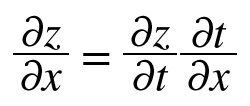

In [96]:
print("t에 대한 z의 미분의 분모, x에 대한 t의 미분의 분자는 상쇄")
fig("e 5.2", w = 200)

위 식 5.2의 국소적 미분(편미분)은 아래 식 5.3과 같음


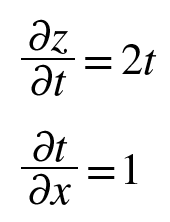

In [101]:
print("위 식 5.2의 국소적 미분(편미분)은 아래 식 5.3과 같음")
fig("e 5.3", w = 120)

편미분 결과를 곱해주면 위 식 5.2가 나오는데, 결국 이는 해석적으로 구한 결과와 일치함


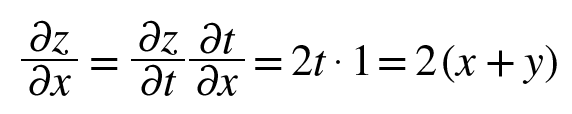

In [107]:
print("편미분 결과를 곱해주면 위 식 5.2가 나오는데, 결국 이는 해석적으로 구한 결과와 일치함")
fig("e 5.4", w = 400)

### 연쇄 법칙과 계산 그래프

식 5.4의 연쇄법칙 계산을 계산 그래프로 나타나면 아래 그림 5-7처럼 그릴 수 있음


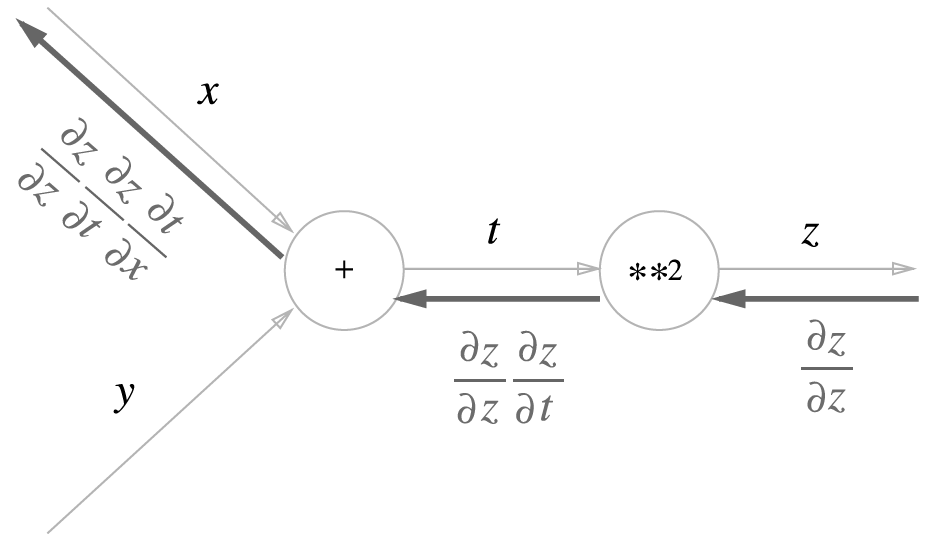

In [109]:
print("식 5.4의 연쇄법칙 계산을 계산 그래프로 나타나면 아래 그림 5-7처럼 그릴 수 있음")
fig("fig 5-7", w = 400)

z에 대한 z에 미분 * t에 대한 z의 미분 * x에 대한 t의 미분을 모두 곱하면(역전파 순서로)

$\cfrac{\partial{z}}{\partial{z}}*\cfrac{\partial{z}}{\partial{t}}*\cfrac{\partial{t}}{\partial{x}} = \cfrac{\partial{z}}{\partial{x}}$이며,

결국 연쇄법칙이 하는 일은 역전파와 동일하다. 그림 5-7에 식 5.3의 결과를 대입하면 아래와 같다.

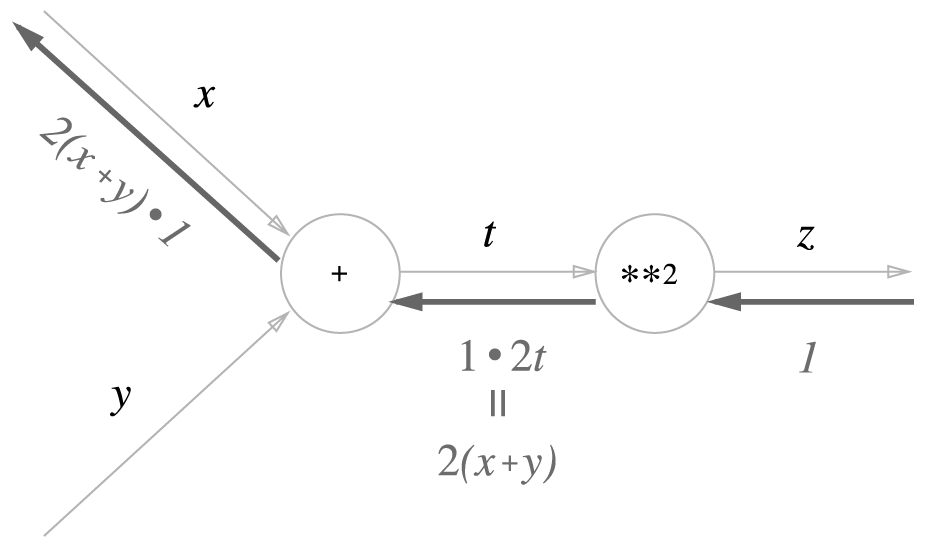

In [111]:
fig("fig 5-8", w = 400)

## 역전파

역전파의 구조

### 덧셈 노드의 역전파

$z = x + y$의 역전파

위 식의 x, y에 대한 z의 미분은 각각 아래와 같이 계산할 수 있음

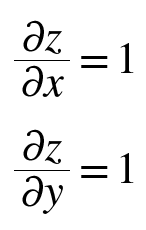

In [115]:
fig("e 5.5", w = 120)

1차 항이므로 미분 결과는 모두 1이 되는데, 이는 계산 그래프로 다음과 같이 그릴 수 있음
덧셈 노드의 역전파는 1을 곱하기만 할 뿐 이다.


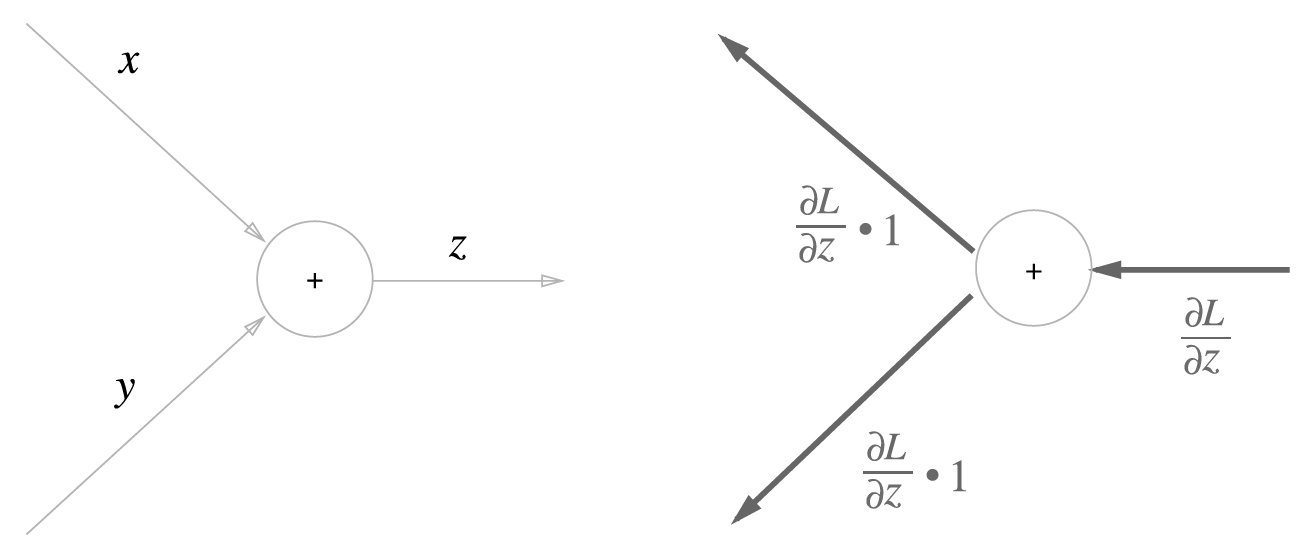

In [118]:
print("1차 항이므로 미분 결과는 모두 1이 되는데, 이는 계산 그래프로 다음과 같이 그릴 수 있음\n"
     "덧셈 노드의 역전파는 1을 곱하기만 할 뿐 이다.")
fig("fig 5-9", w = 500)

덧셈 노드의 예 - 상위 노드에서 흘려온 값을 다음 하위 노드에 그대로 전달한다.


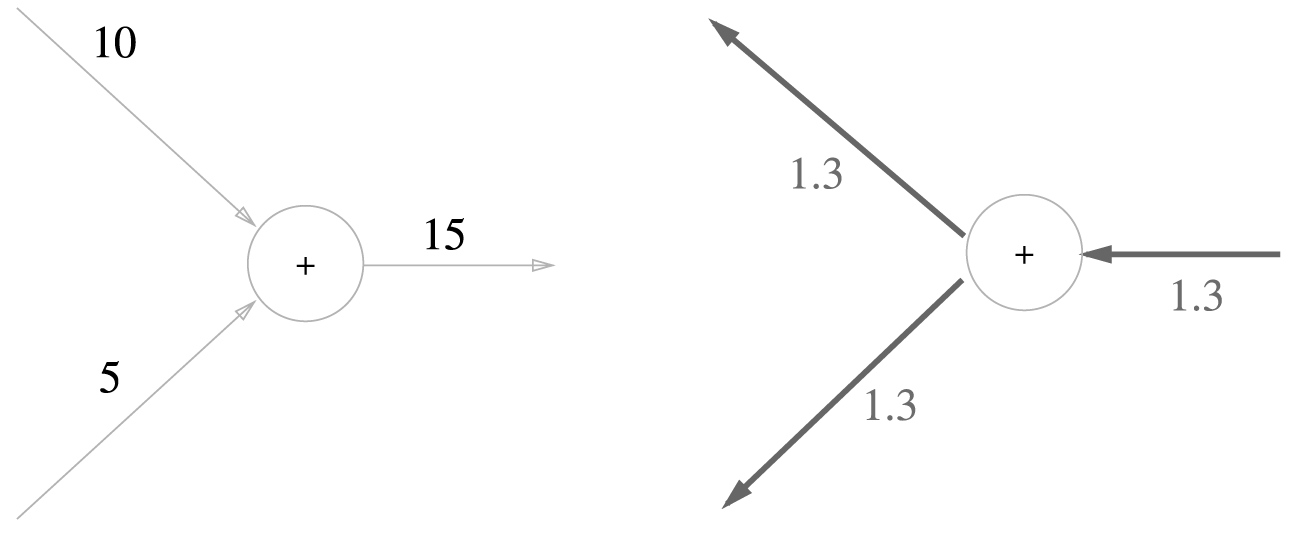

In [121]:
print("덧셈 노드의 예 - 상위 노드에서 흘려온 값을 다음 하위 노드에 그대로 전달한다.")
fig("fig 5-11", w = 500)

### 곱셈 노드의 역전파

$z = xy$의 역전파
위 식의 x, y에 대한 z의 미분은 각각 아래와 같이 계산할 수 있음

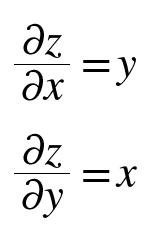

In [125]:
fig("e 5.6", w = 100)

1차 항이면서 다른 변수가 존재하기 때문에 미분 결과는 x 또는 y가 되는데, 이는 계산 그래프로 다음과 같이 그릴 수 있음
--> 순전파에서 x였다면, 역전파에서는 y가 된다.


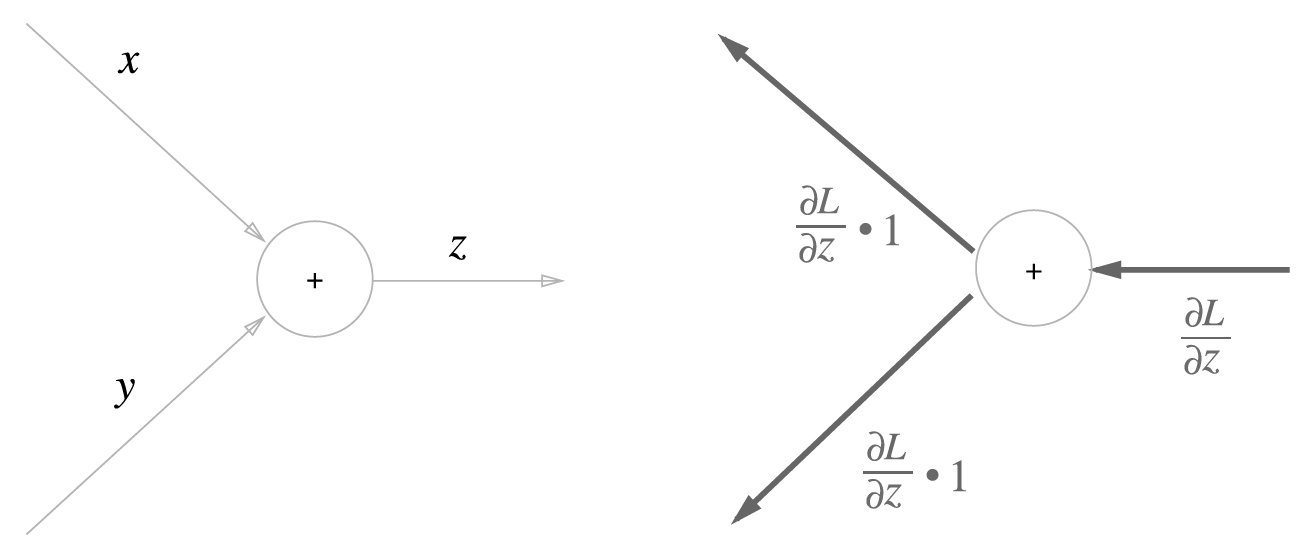

In [126]:
print("1차 항이면서 다른 변수가 존재하기 때문에 미분 결과는 x 또는 y가 되는데, 이는 계산 그래프로 다음과 같이 그릴 수 있음\n"
     "--> 순전파에서 x였다면, 역전파에서는 y가 된다.")
fig("fig 5-9", w = 500)

곱셈 노드의 예 - 상위 노드에서 흘려온 값을 다음 하위 노드에 그대로 전달하는데, 이 때 곱해지는 값의 순서가 바뀐다.
변수가 여러 개인 미분의 성질을 생각하면 당연한 결과


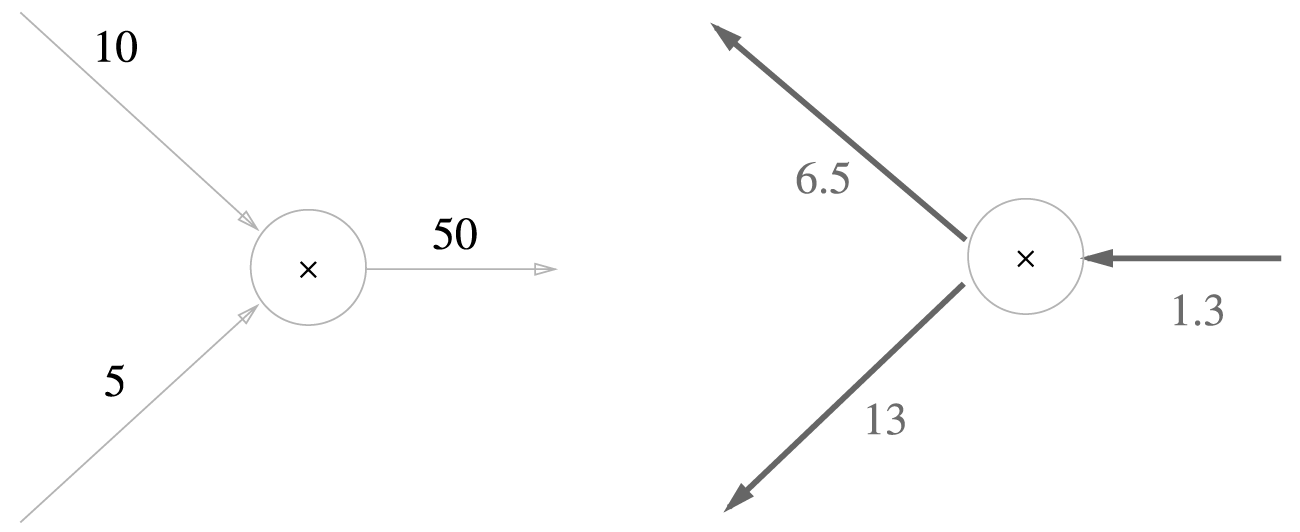

In [130]:
print("곱셈 노드의 예 - 상위 노드에서 흘려온 값을 다음 하위 노드에 그대로 전달하는데, 이 때 곱해지는 값의 순서가 바뀐다.\n"
     "변수가 여러 개인 미분의 성질을 생각하면 당연한 결과")
fig("fig 5-13", w = 500)

### 사과 쇼핑의 예

사과의 가격, 사과의 개수, 부가세 총 세 가지 변수의 변화가 최종 금액에 어떻게 영향을 주는지

이를 역전파로 풀면 아래와 같은 계산 그래프로 나타낼 수 있음

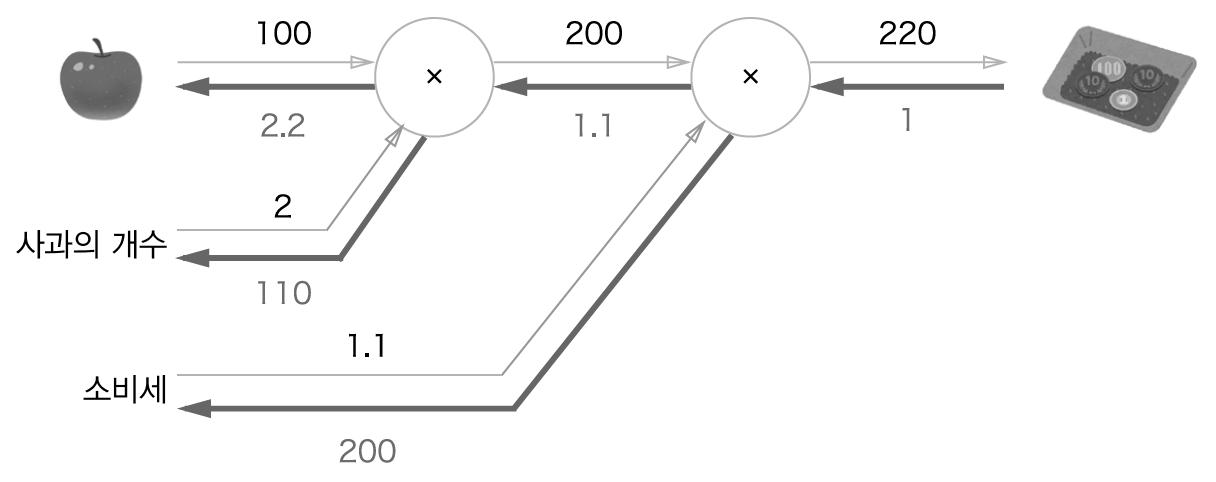

In [132]:
fig("fig 5-14", w = 450)

출력에 대한 출력의 미분은 1

출력은 사과 (갯수*가격) * 소비세 = (100 * 2) * 1.1 = 200 * 1.1  이므로

두 번째 곱셈 노드의 미분은 200

사과의 가격, 개수 노드의 출력값은 사과의 갯수 * 가격 = 100 * 2 이므로

사과의 가격에 대한 역전파에 의한 미분 값은 1.1 * 2 = 2.2

사과의 개수에 대한 역전파에 의한 미분 값은 1.1 * 100 = 110

## 단순한 계층 구현하기

그래프의 곱셈 노드를 'MullLayer'

덧셈 노드를 'AddLayer'로 구현함


### 곱셈 계층

모든 계층은 forward()와 backward()라는 공통의 method를 갖도록 구현(전자는 순전파, 후자는 역전파)

In [8]:
class MulLayer:
  def __init__(self): 
    self.x = None # 
    self.y = None

  def forward(self, x, y):
    self.x = x
    self.y = y
    out = x * y
    
    return out
  
  def backward(self, dout):
    dx = dout * self.y # x와 y를 바꾼다
    dy = dout * self.x # x와 y를 바꾼다
    
    return dx, dy


앞 절에서는 계산그래프의 순전파와 역전파를 활용해서 아래와 같이 계산했음


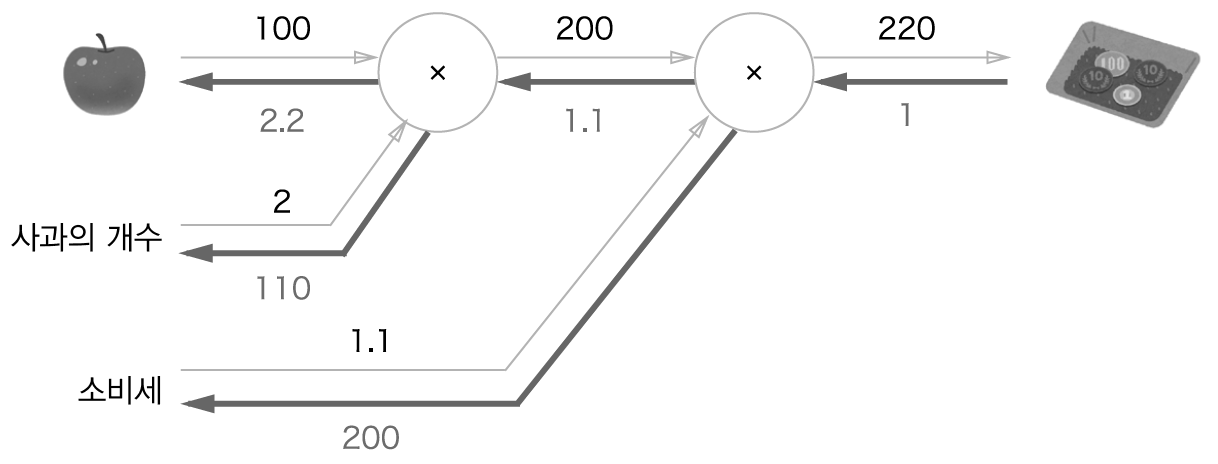

In [10]:
print("앞 절에서는 계산그래프의 순전파와 역전파를 활용해서 아래와 같이 계산했음")
fig("fig 5-16", w = 450)

In [9]:
print("MulLayer를 사용한 순전파는 아래와 같음")

apple = 100
apple_num = 2
tax = 1.1

#계층
mul_apple_layer = MulLayer() # 사과 기준 MulLayer() 클래스 객체 생성
mul_tax_layer = MulLayer() # 택스 기준 MulLayer() 클래스 객체 생성

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num) # mul_apple_layer의 forward method를 활용해서 apple_price 객체 생성
price = mul_tax_layer.forward(apple_price, tax) # mul_tax_layer의 forward method를 활용해서 price(total) 객체 생성

print(price)

MulLayer를 사용한 순전파는 아래와 같음
220.00000000000003


In [10]:
print("각 변수에 대한 편미분은 backward를 통해 구할 수 있음")

# 역전파
dprice = 1 # 최종 가격의 자기 자신에 대한 미분이니까 당연히 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

각 변수에 대한 편미분은 backward를 통해 구할 수 있음
2.2 110.00000000000001 200


### 덧셈 계층

In [11]:
print("덧셈 노드 구현")

class AddLayer:
  def __init__(self):
    pass # 초기화가 필요 없어서 pass(인스턴스 호출만)
  
  def forward(self, x, y):
    out = x + y # x, y를 더해서 out을 반환
    return out

  def backward(self, dout):
    dx = dout * 1
    dy = dout * 1
    
    return dx, dy


덧셈 노드 구현


In [13]:
print("곱셈노드와 덧셈노드를 활용하여 사과, 오렌지 계산그래프를 구현하면 아래와 같은 결과가 나오는데, 계산 그래프가 머리속에 있다면 왜 이렇게 코드를 구현하는지 이해될 것")

apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
apple_orange_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(apple_orange_price, tax)

# backward

dprice = 1
dapple_orange_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dapple_orange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)

print("total_price is " + str(price)) # total_price
print("dapple: {}, dapple_num: {}, dorange: {}, dorange_num: {}, dapple_orange_price: {}, dtax: {}".format(dapple, dapple_num, dorange, dorange_num, dapple_orange_price, dtax))


곱셈노드와 덧셈노드를 활용하여 사과, 오렌지 계산그래프를 구현하면 아래와 같은 결과가 나오는데, 계산 그래프가 머리속에 있다면 왜 이렇게 코드를 구현하는지 이해될 것
total_price is 715.0000000000001
dapple: 2.2, dapple_num: 110.00000000000001, dorange: 3.3000000000000003, dorange_num: 165.0, dapple_orange_price: 1.1, dtax: 650


## 활성화 함수 계층 구현하기

### ReLU 계층

활성화 함수로 사용되는 ReLU의 수식은 아래와 같음


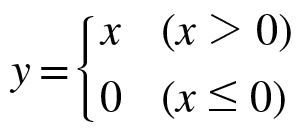

In [41]:
print("활성화 함수로 사용되는 ReLU의 수식은 아래와 같음")
fig("e 5.7")

위 식에서 x에 대한 y의 미분은 아래와 같이 구함


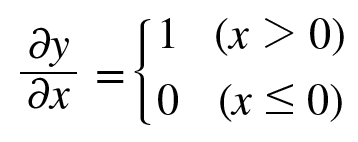

In [42]:
print("위 식에서 x에 대한 y의 미분은 아래와 같이 구함")
fig("e 5.8")

식 5.8에서와 같이 입력인 $x$가 0보다 크면 역전파는 상류의 값을 그대로 하류로 흘림.

반면, 순전파 때 $x$가 0 이하면 역전파 때는 하류로 신호를 보내지 않음(0을 보냄)

이 때의 계산 그래프는 아래 5-18처럼 그릴 수 있음

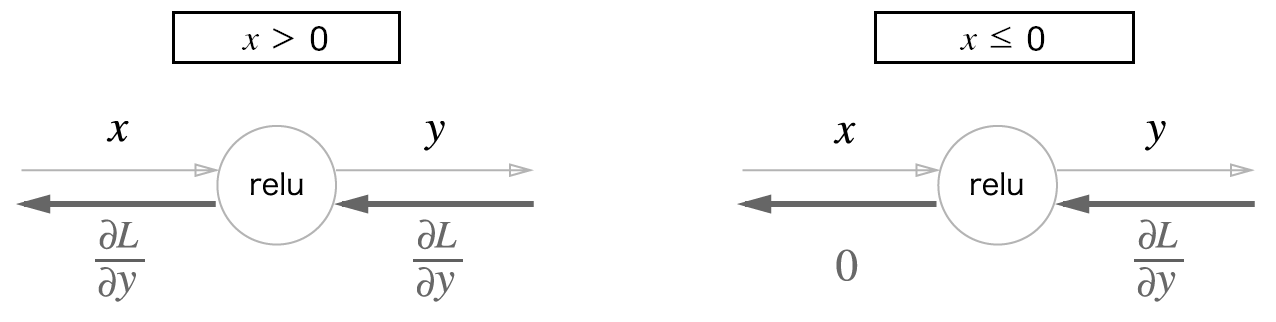

In [44]:
fig("fig 5-18", w = 500)

In [17]:
print("ReLU 계층의 구현")

class Relu:
  def __init__(self):
    self.mask = None

    
  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0
      
    return out
  
  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout
    
    return dx

ReLU 계층의 구현


In [19]:
#mask = True / False로 구성된 np.array로, 순전파의 입력인 x의 원소의 값이 0 이하인 경우 True, 0보다 크면 False로 유지.
x = np.array([[1.0, -0.5], [-2.0, 3.0]])
print(x)

mask = (x <= 0)
print(mask)

[[ 1.  -0.5]
 [-2.   3. ]]
[[False  True]
 [ True False]]


In [20]:
relu = Relu()
relu.forward(np.array([[1.0, -0.5], [-2.0, 3.0]]))



array([[1., 0.],
       [0., 3.]])

In [22]:
relu.backward(np.array([[1.0, -0.5], [-2.0, 3.0]]))
#순전파 때 x <= 0이면 역전파 때에도 값을 전달하지 않음

array([[1., 0.],
       [0., 3.]])

### Sigmoid 계층

시그모이드 함수 수식


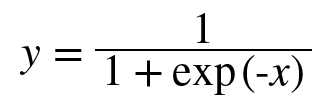

In [23]:
print("시그모이드 함수 수식")
fig("e 5.9", w = 300)

시그모이드 함수 수식을 계산그래프로 표현한 것


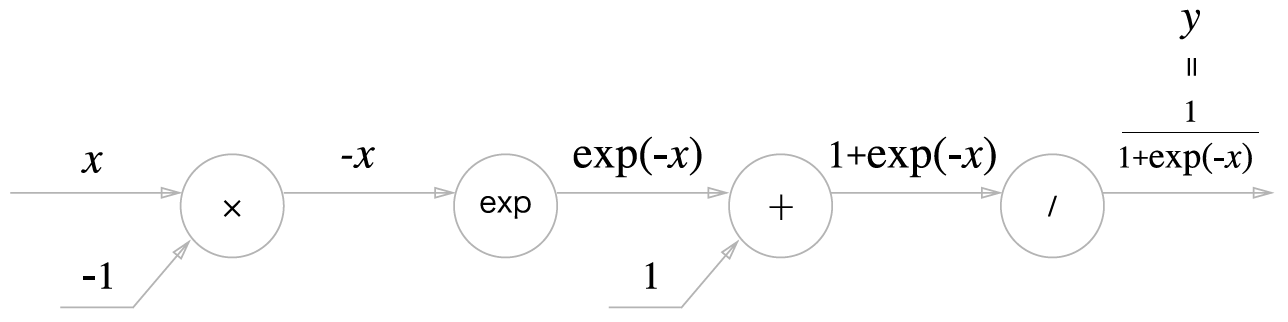

In [24]:
print("시그모이드 함수 수식을 계산그래프로 표현한 것")
fig("fig 5-19", w = 500)

#### 사실 이해는 잘 안감
**아래 단계에서 $x = 1+exp(-x)$를 의미함**


**1단계**

'/'노드(나누기 노드)의 분자를 $x$로 치환하면, 즉 $y =  \cfrac{1}{x}$을 미분하면 아래와 같은 식이 된다.


$\cfrac{\partial{y}}{\partial{x}} = -\cfrac{1}{x^2} = -y^2$  

(순전파의 출력을 제곱한 후 마이너스를 붙인 값)

  
**2단계**

'+' 노드는 상류의 값을 그대로 흘려줌

  
**3단계**

'exp' 노드는 $y = exp(x)$ 연산을 수행하며, 그 미분은 다음과 같음

$$ \cfrac{\partial{y}}{\partial{x}} = exp(x) $$

계산 그래프에서는 상류의 값에 순전파 때의 출력(이 예에서는 $exp(-x))을 곱해 하류로 전파함


**4단계**

'x' 노드는 순전파 때의 값을 '서로 바꿔' 곱함. 이 예에서는 -1을 곱하면 됨**

Sigmoid 계층의 계산그래프


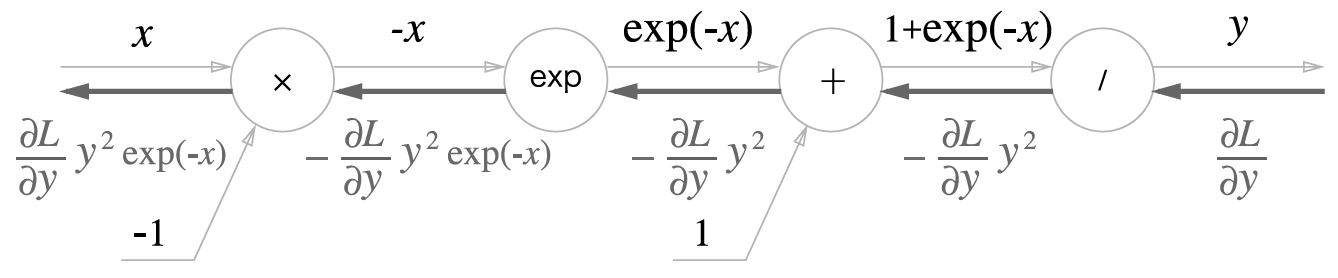

In [17]:
print("Sigmoid 계층의 계산그래프")
fig("fig 5-20", w = 600)

Sigmoid 계층의 계산 그래프(간소화 버전)


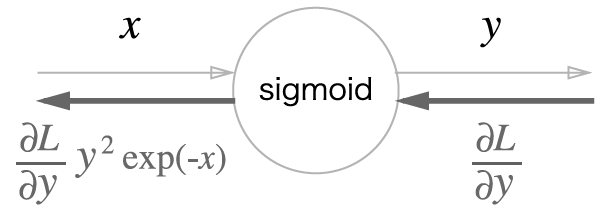

In [18]:
print("Sigmoid 계층의 계산 그래프(간소화 버전)")
fig("fig 5-21", w = 300)

위 그림 5-21의 최종식을 다시 정리해서 쓰면 아래와 같이 정리할 수 있는데, 결국 Sigmoid 계층의 역전파는
순전파의 출력(y)만으로 계산할 수 있다.


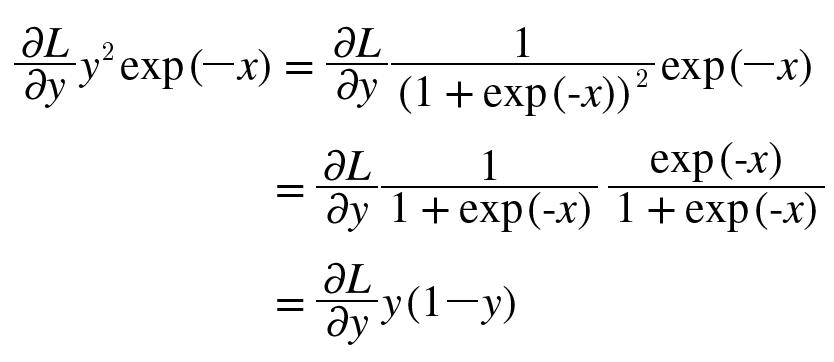

In [22]:
print("위 그림 5-21의 최종식을 다시 정리해서 쓰면 아래와 같이 정리할 수 있는데, 결국 Sigmoid 계층의 역전파는\n"
     "순전파의 출력(y)만으로 계산할 수 있다.")

fig("e 5.12", w = 400)
# y = 1 / 1 + exp(-x)니까 
# 아래 식(미분 제외하고)은 y * y * exp(-x)로 정리할 수 있고
# exp(-x)를 y에 대한 식으로 바꿔보면
# exp(-x) = 1/y - 1 니까
# y * y(1/y -1) = y(1-y)

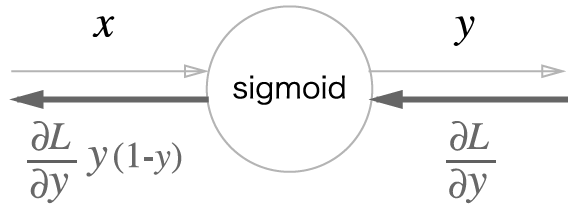

In [23]:
fig("fig 5-22", w = 400)

In [56]:
from other.common.functions import *

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        
        return out

    def backward(self, dout):
        dx = dout * self.out * (1.0 - self.out)

        return dx

In [57]:
sigm = Sigmoid()
for_out = sigm.forward(3.0)

back_out = sigm.backward(out)

print(for_out, back_out)

0.9525741268224334 0.04303411719592769


## Affine / Softmax 계층 구현하기(출력층 활성화함수)

### Affine 계층 - 신경망의 순전파 때 수행하는 행렬의 곱을 기하학에서 Affine Transformation이라 표현함

In [6]:
# 신경망의 순전파에서는 가중치 신호의 총합을 계산하기 위해 행렬의 곱(np.dot())을 사용하였음(3.3 다차원 배열의 계산)

X = np.random.rand(2) # 입력
W = np.random.rand(2,3) # 가중치
B = np.random.rand(3) # 편향

print(X.shape, X)
print(W.shape, W)
print(B.shape, B)

Y = np.dot(X, W) + B # X와 W의 행렬곱( (2,) * (2,3) = 에 B의 값을 더해줌
print(Y)

(2,) [0.91866564 0.12685984]
(2, 3) [[0.61416319 0.97055988 0.92752329]
 [0.71401225 0.33204804 0.92285153]]
(3,) [0.60592268 0.51373471 0.91176793]
[1.26071278 1.44747828 1.88092451]


X * W = Y


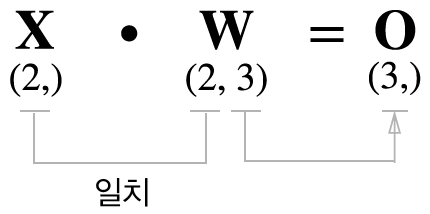

In [7]:
print("X * W = Y")
fig("fig 5-23")

Affine 계층의 계산 그래프 - 변수가 행렬인 것에 유의해야 한다.


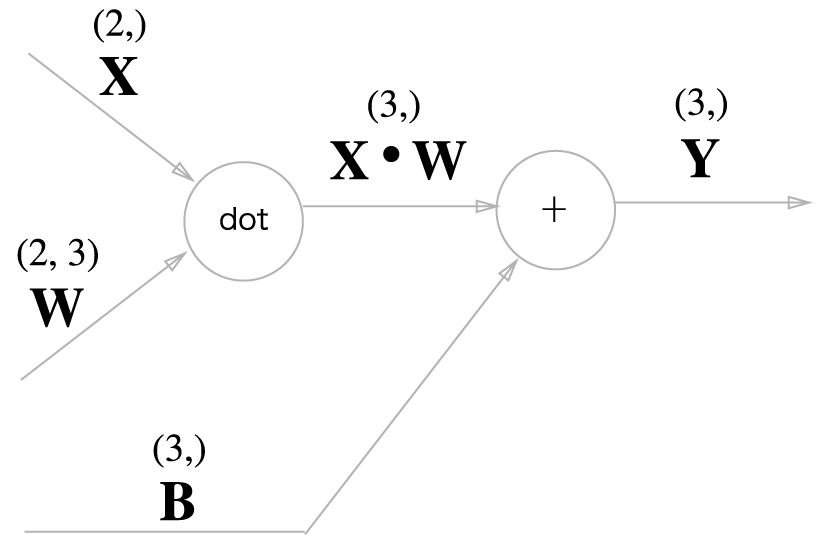

In [8]:
print("Affine 계층의 계산 그래프 - 변수가 행렬인 것에 유의해야 한다.")
fig("fig 5-24", w = 400)

In [9]:
np.dot(X, W)

array([0.6547901 , 0.93374357, 0.96915658])

In [10]:
B

array([0.60592268, 0.51373471, 0.91176793])

In [11]:
np.dot(X, W) + B

array([1.26071278, 1.44747828, 1.88092451])

In [12]:
a = np.array([1, 2]) #(2,)
b = np.array([[1,2,3], [1,2,3]]) # (2,3) -> transpose하면 (3,2)
np.dot(a, b)

array([3, 6, 9])

Y = WX + B의 역전파 수식


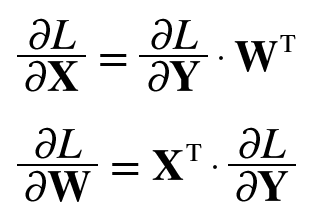

In [13]:
print("Y = WX + B의 역전파 수식")
fig("e 5.13", w = 300)

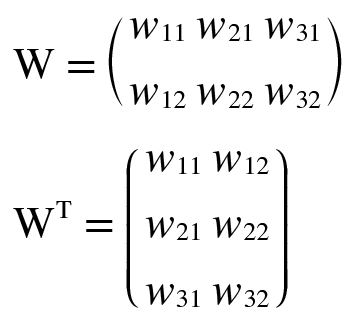

In [14]:
fig("e 5.14", w = 300)

In [28]:
print("train set에서 무작위로 10장만 빼내려면 np.random.choice() 함수를 활용함")

train_size = x_train.shape[0] # [0] == 60000   [1] == 784
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

train set에서 무작위로 10장만 빼내려면 np.random.choice() 함수를 활용함


In [29]:
print("이를 실제로 실행해보면 아래와 같이 무작위로 10개의 array(==행)를 출력함 \n"
     "이렇게 뽑힌 array를 미니배치의 index로 활용하는 것")
np.random.choice(60000, 10)

이를 실제로 실행해보면 아래와 같이 무작위로 10개의 array(==행)를 출력함 
이렇게 뽑힌 array를 미니배치의 index로 활용하는 것


array([ 7132, 29029, 14229, 33615, 26267, 51034, 52484, 23018, 45714,
       52157])

### (배치용) 교차 엔트로피 오차 구현하기

In [30]:
print("미니배치를 활용하는 경우 & 원핫인코딩 상태 데이터에 대한 교차 엔트로피 오차는 이렇게 구현함")

def cross_entropy_error(y, t):
    if y.dim == 1: # 이 조건절을 넣는 이유는 y가 1차원, 즉, 데이터 array 하나당 교차 엔트로피를 구할 경우(==배치사이즈가 1인 경우)
                   # reshape함수로 데이터의 형상을 바꿔주기 위함
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    delta = 1e-7
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + delta)) / batch_size

미니배치를 활용하는 경우 & 원핫인코딩 상태 데이터에 대한 교차 엔트로피 오차는 이렇게 구현함


In [31]:
print("미니배치를 활용하는 경우 & 원핫인코딩이 아닌 입력값 그대로 데이터에 대한 교차 엔트로피 오차는 이렇게 구현함 \n"
     "->원핫인코딩 상태인 경우 t(실젯값)가 0이면 return도 0이므로 t*np.log(y)부분을 np.log(y[np.arange(batch_size), t])로 구현 \n"
     "batch_size가 5인 경우 np.arange(batch_size)는 [0, 1, 2, 3, 4]의 np.array를 생성하고, \n"
      "t에는 레이블이 [2, 7, 0, 9, 4]와 같이 저장되어 있으므로 y[np.arange(batch_size), t]는 [y[0, 2], y[1, 7], y[2, 0], y[3, 9], y[4, 4]]인 np.array를 생성함")

def cross_entropy_error(y, t):
    if y.dim == 1: # 이 조건절을 넣는 이유는 y가 1차원, 즉, 데이터 array 하나당 교차 엔트로피를 구할 경우(==배치사이즈가 1인 경우)
                   # reshape함수로 데이터의 형상을 바꿔주기 위함
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    delta = 1e-7
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + delta)) / batch_size

미니배치를 활용하는 경우 & 원핫인코딩이 아닌 입력값 그대로 데이터에 대한 교차 엔트로피 오차는 이렇게 구현함 
->원핫인코딩 상태인 경우 t(실젯값)가 0이면 return도 0이므로 t*np.log(y)부분을 np.log(y[np.arange(batch_size), t])로 구현 
batch_size가 5인 경우 np.arange(batch_size)는 [0, 1, 2, 3, 4]의 np.array를 생성하고, 
t에는 레이블이 [2, 7, 0, 9, 4]와 같이 저장되어 있으므로 y[np.arange(batch_size), t]는 [y[0, 2], y[1, 7], y[2, 0], y[3, 9], y[4, 4]]인 np.array를 생성함


### 왜 손실 함수를 설정했는가

In [32]:
print("Accuracy, recall, precision 등의 지표가 아니라 왜 손실함수라는 우회적인 방법을 택하는 것인가?\n"
     "미분의 역할에 주목한다면 해결되는 문제 -> \n"
      "신경망에서는 최적의 매개변수(가중치, 편향)를 탐색할 때 손실함수의 값을 가능한 한 작게하는 방향으로 탐색을 하는데, \n"
     "미분(정확히는 기울기)을 하고 이 미분 값을 단서로 매개변수 값을 서서히 갱신하는 과정을 반복한다.\n"
     "즉, 매개변수를 순간변화시켰을 때, 손실함수의 변화는 어떤가?에 초점을 맞춘다는 의미(미분계수가 음수면 양의방향으로 변화시키고, \n"
     "미분계수가 양수면 음의방향으로 변환시킨다는 말")

Accuracy, recall, precision 등의 지표가 아니라 왜 손실함수라는 우회적인 방법을 택하는 것인가?
미분의 역할에 주목한다면 해결되는 문제 -> 
신경망에서는 최적의 매개변수(가중치, 편향)를 탐색할 때 손실함수의 값을 가능한 한 작게하는 방향으로 탐색을 하는데, 
미분(정확히는 기울기)을 하고 이 미분 값을 단서로 매개변수 값을 서서히 갱신하는 과정을 반복한다.
즉, 매개변수를 순간변화시켰을 때, 손실함수의 변화는 어떤가?에 초점을 맞춘다는 의미(미분계수가 음수면 양의방향으로 변화시키고, 
미분계수가 양수면 음의방향으로 변환시킨다는 말


In [33]:
print("Accuracy를 매개변수 조정의 지표로 삼게되면, 매개변수의 미분값이 대부분의 장소에서(local, global) 0이 될 것임\n"
     "예를 들어, Accuracy가 32%일 경우 매개변수를 약간 조정하게 되면 32.0000132%가 아니라 33%, 34%등의 띄엄띄엄한 값으로 바뀜\n"
     "손실함수의 경우에는 매개변수의 값이 조금만 조정되면 손실함수의 값도 조금만 조정됨\n"
     "Accuracy를 사용하지 않는 이유는 결국 계단함수를 활성화함수로 사용하지 않는 것과 비슷한 이치임")

Accuracy를 매개변수 조정의 지표로 삼게되면, 매개변수의 미분값이 대부분의 장소에서(local, global) 0이 될 것임
예를 들어, Accuracy가 32%일 경우 매개변수를 약간 조정하게 되면 32.0000132%가 아니라 33%, 34%등의 띄엄띄엄한 값으로 바뀜
손실함수의 경우에는 매개변수의 값이 조금만 조정되면 손실함수의 값도 조금만 조정됨
Accuracy를 사용하지 않는 이유는 결국 계단함수를 활성화함수로 사용하지 않는 것과 비슷한 이치임


계단함수는 불연속적인 변화로 인해 대부분의 위치에서 기울기가 0이지만(== 한 순간만 변하고 만다.), 시그모이드 함수는 0이 아니다.
이러한 이유로 신경망 학습에서는 기울기가 0이 되지 않는 손실함수를 활용하여 학습이 진행되는 것


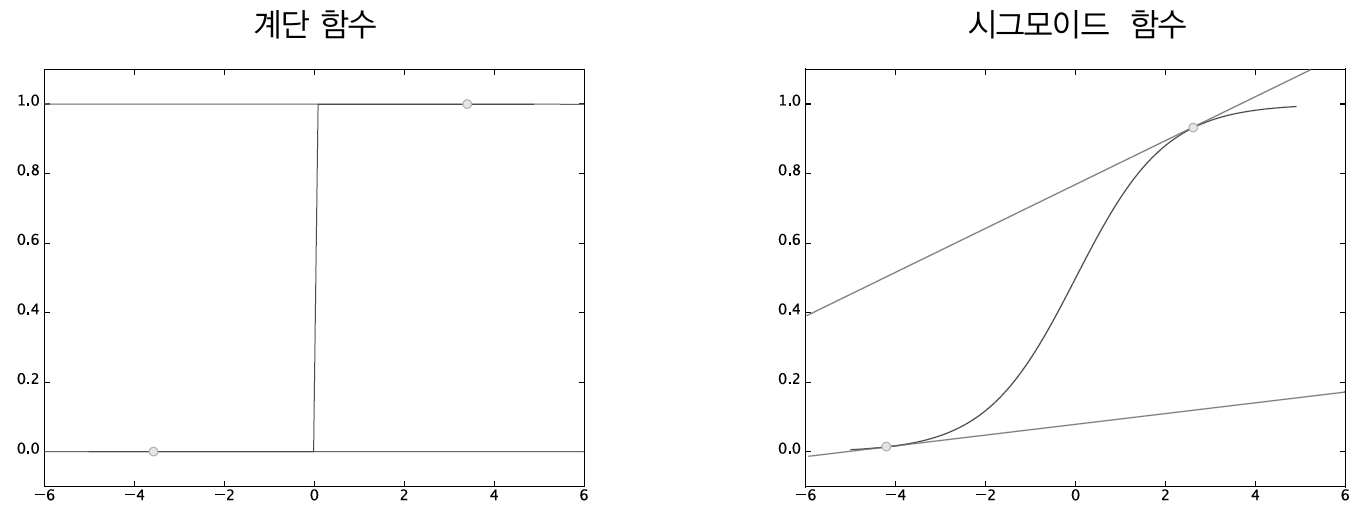

In [34]:
print("계단함수는 불연속적인 변화로 인해 대부분의 위치에서 기울기가 0이지만(== 한 순간만 변하고 만다.), 시그모이드 함수는 0이 아니다.\n"
     "이러한 이유로 신경망 학습에서는 기울기가 0이 되지 않는 손실함수를 활용하여 학습이 진행되는 것")
fig("fig 4-4", w = 700)

## 수치 미분

In [35]:
print("경사법에서는 기울기(경사)의 값을 기준으로 나아갈 방향을 결정함")

경사법에서는 기울기(경사)의 값을 기준으로 나아갈 방향을 결정함


### 미분

도함수: df(x)는 dx의 몇 배인가? -> 작은 변화(dx)는 f(x)를 얼마나 변화시키냐? 
함수의 값이 0에 한없이 가까워지는 극한값(미분계수)을 구하는 함수


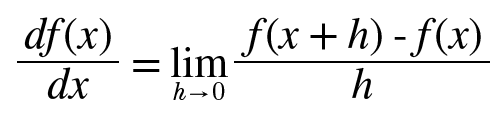

In [36]:
print("도함수: df(x)는 dx의 몇 배인가? -> 작은 변화(dx)는 f(x)를 얼마나 변화시키냐? \n"
     "함수의 값이 0에 한없이 가까워지는 극한값(미분계수)을 구하는 함수")
fig("e 4.4", w = 400)

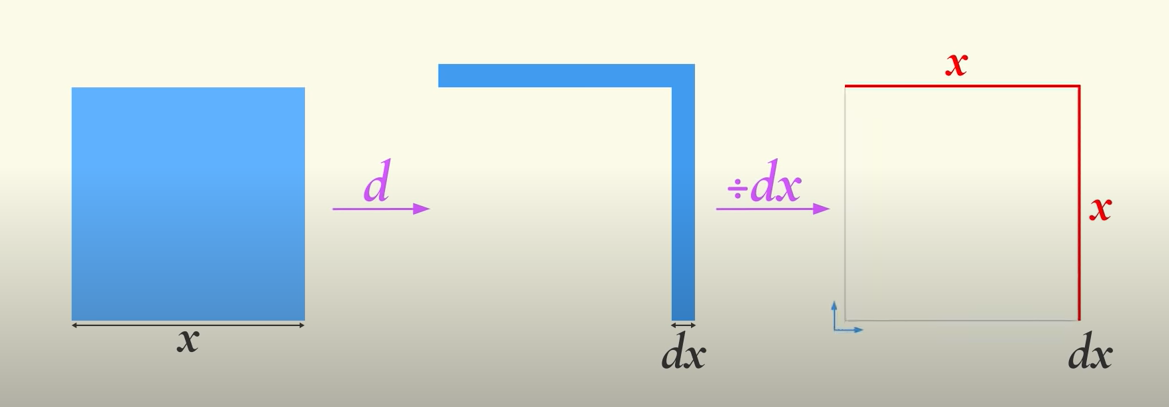

In [37]:
fig("미분_", w = 600)

In [38]:
# 나쁜 구현의 예

def numerical_diff(f, x):
    h = 10e-50
    return (f(x + h) - f(x)) / h

h에 가급적 작은 변화를 주고싶어서 10e-50을 할당했는데, float32로 표현하면 0.0이 되어버림. 보통 10^-4를 적용함
또한 f의 차분(f(x + h)와 f(x)의 차이)과 관련한 것인데, 진정한 미분은 아래 그림의 x위치의 진정한 접선(기울기)여야 하지만 위 함수에서의 기울기는 x와 x+h 사이의 연결선이 구현됨
이 차이는 h를 무한히 0으로 좁히는 것이 불가능하여 발생하는 한계


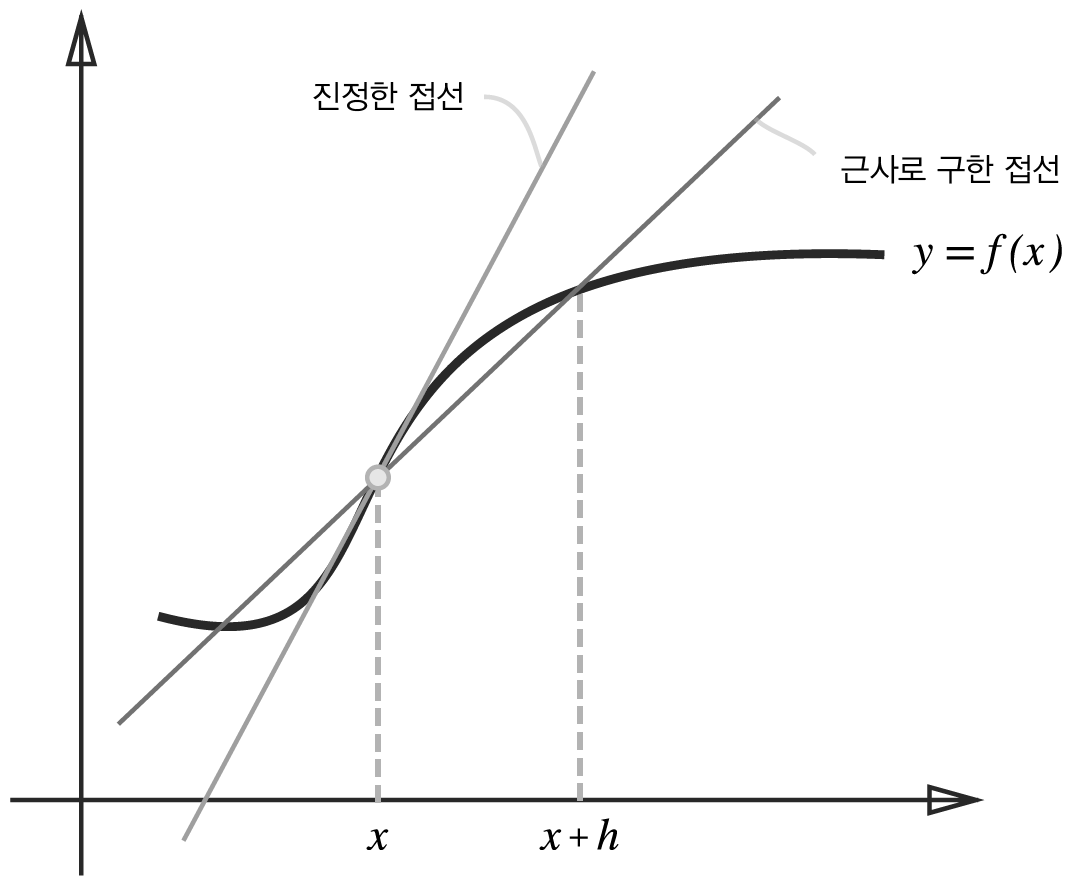

In [39]:
print("h에 가급적 작은 변화를 주고싶어서 10e-50을 할당했는데, float32로 표현하면 0.0이 되어버림. 보통 10^-4를 적용함\n"
     "또한 f의 차분(f(x + h)와 f(x)의 차이)과 관련한 것인데, 진정한 미분은 아래 그림의 x위치의 진정한 접선(기울기)여야 하지만 위 함수에서의 기울기는 x와 x+h 사이의 연결선이 구현됨\n"
     "이 차이는 h를 무한히 0으로 좁히는 것이 불가능하여 발생하는 한계")
fig("fig 4-5", w = 400)

In [40]:
# 개선 후 구현
def numerical_diff(f, x):
    h = 1e-4
    return (f(x + h) - f(x - h)) / (2 * h)

### 수치 미분의 예(<> 해석학적 미분 = 우리가 일반적으로 배운 미분)

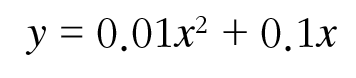

In [41]:
fig("e 4.5")

In [42]:
# 위 식 4.5를 구현

def function_1(x):
    return 0.01 * (x ** 2) + (0.1 * x) 

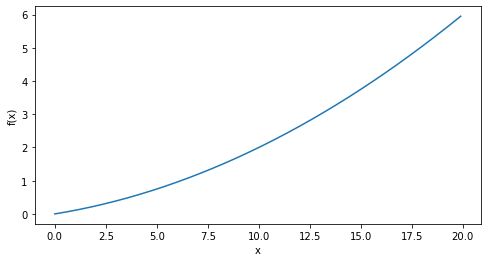

In [43]:
plt.figure(figsize=(8,4))
x = np.arange(0.0, 20.0, 0.1) # 0부터 20까지 0.1 간격으로 
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

In [44]:
print("수치미분 x = 5: " + str(numerical_diff(function_1, 5)))
print("수치미분 x = 10: " + str(numerical_diff(function_1, 10)))

수치미분 x = 5: 0.1999999999990898
수치미분 x = 10: 0.2999999999986347


In [45]:
len(np.array([1,2]))

2

In [46]:
x = np.array([5, 10])
for i in range(len(x)):
    print("해석미분 x = {}: ".format(x[i]) + str(0.02 * x[i] + 0.1))
print("작은 오차!")

해석미분 x = 5: 0.2
해석미분 x = 10: 0.30000000000000004
작은 오차!


x = 5, x = 10에서의 접선(직선의 기울기는 수치 미분 기준 == 근사)


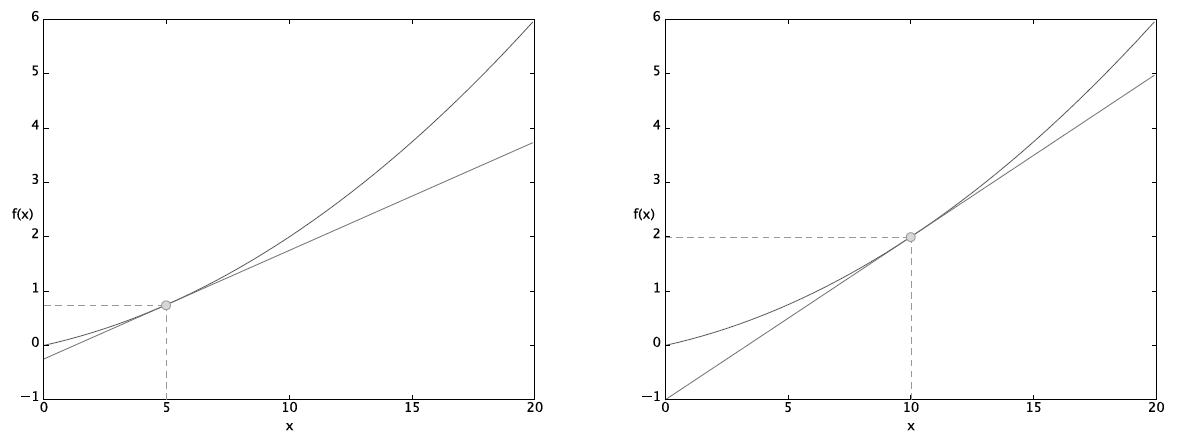

In [47]:
print("x = 5, x = 10에서의 접선(직선의 기울기는 수치 미분 기준 == 근사)")
fig("fig 4-7", w = 600)

### 편미분(다변수 함수의 미분)

인수들의 제곱 합을 계산하는 단순한 식이지만, 앞의 예와 달리 변수가 2개


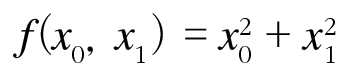

In [48]:
print("인수들의 제곱 합을 계산하는 단순한 식이지만, 앞의 예와 달리 변수가 2개")
fig("e 4.6", w = 400)

In [49]:
def function_2(x):
#     return x[0] ** 2 + x[1] ** 2
    return np.sum(x ** 2)

In [50]:
function_2(np.array([15,16]))

481

위 식 4.6의 함수를 그래프로 표현할 경우 3차원으로 표현됨


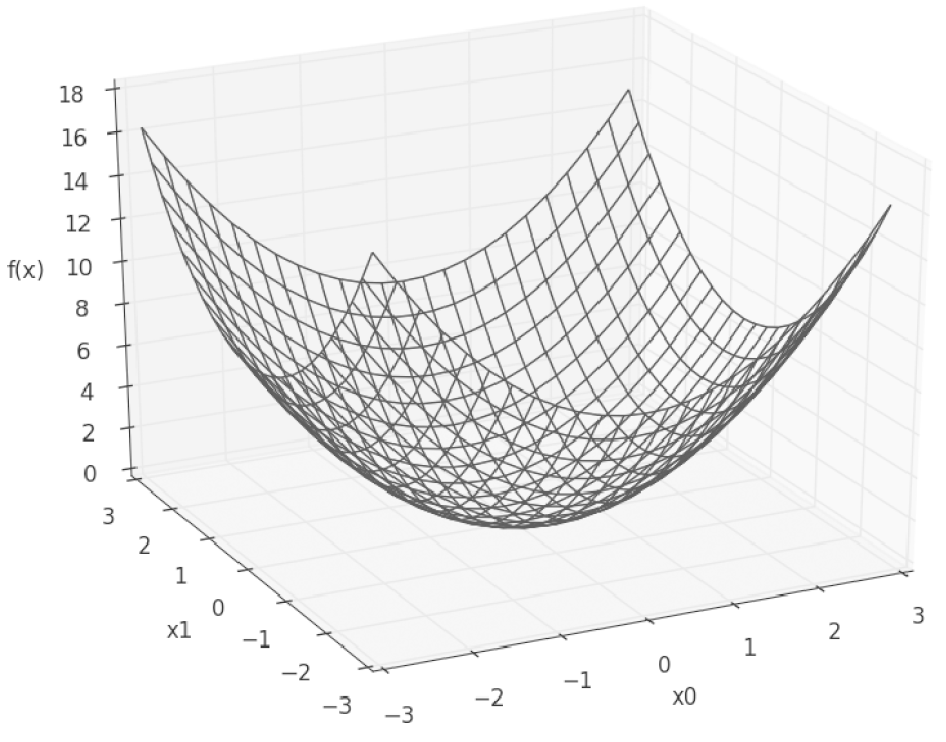

In [51]:
print("위 식 4.6의 함수를 그래프로 표현할 경우 3차원으로 표현됨")
fig("fig 4-8", w = 500)

In [52]:
print("식 4.6을 미분할 경우, 변수가 2개라서 어느 변수에 대한 미분인지를 반드시 구별해야함.== 편미분\n"
     "여기서 어떤 변수 x에 대한 미분이라는 의미는, x이외의 변수는 상수처럼 취급하라는 말이다.\n"
     "z = wx + b가 주어졌을 대, w에 대한 미분인 경우 x가, x에 대한 미분일 경우에는 w가, b에 대한 미분일 경우에는 1이. 미분결과로 산출")

식 4.6을 미분할 경우, 변수가 2개라서 어느 변수에 대한 미분인지를 반드시 구별해야함.== 편미분
여기서 어떤 변수 x에 대한 미분이라는 의미는, x이외의 변수는 상수처럼 취급하라는 말이다.
z = wx + b가 주어졌을 대, w에 대한 미분인 경우 x가, x에 대한 미분일 경우에는 w가, b에 대한 미분일 경우에는 1이. 미분결과로 산출


In [53]:
print("x_0 = 3, x_1 = 4일 때, x_0에 대한 편미분을 구하라")

def function_tmp1(x0):
    return x0 ** 2 + 4 ** 2
numerical_diff(function_tmp1, 3)

x_0 = 3, x_1 = 4일 때, x_0에 대한 편미분을 구하라


6.00000000000378

In [54]:
print("해석학적 결과")
2 * 3 + 0

해석학적 결과


6

In [55]:
print("x_0 = 3, x_1 = 4일 때, x_1에 대한 편미분을 구하라")

def function_tmp2(x1):
    return 3 ** 2 + x1 ** 2
numerical_diff(function_tmp2, 4)

x_0 = 3, x_1 = 4일 때, x_1에 대한 편미분을 구하라


7.999999999999119

In [56]:
print("해석학적 결과")
2 * 4 + 0

해석학적 결과


8

## 기울기

In [57]:
print("x_0와 x_1의 편미분을 변수별로 따로 계산하지 않고, 동시에 계산하고 싶다면?")

x_0와 x_1의 편미분을 변수별로 따로 계산하지 않고, 동시에 계산하고 싶다면?


가령 $x_{0} = 3$, $x_1 = 4$일 때, $(x_{0}, x_{1})$ 양쪽의 편미분을 묶어서 $(\frac{∂f}{∂x_0}, \frac{∂f}{∂x_1})$ 을 계산 한다고 생각해보자.

이 때 $(\frac{∂f}{∂x_0}, \frac{∂f}{∂x_1})$처럼 모든 변수의 편미분을 벡터로 정리한 것을 기울기$^{gradient}$라고 한다.

In [58]:
print("기울기 구현")
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # 주어진 array와 shape가 동일한 zeros array 생성
    
    for idx in range(x.size):
        tmp_val = x[idx] 
        
        # f(x + h) 계산
        x[idx] = tmp_val + h 
        fxh1 = f(x)
        
        # f(x - h) 계산
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val # 값 복원
    
    return grad

기울기 구현


In [59]:
np.zeros_like([[1,2,3],[1,2,3]])

array([[0, 0, 0],
       [0, 0, 0]])

In [60]:
print("점 3, 4의 기울기:" ,str(numerical_gradient(function_2, np.array([3.0, 4.0]))))
print("점 0, 2의 기울기:" ,str(numerical_gradient(function_2, np.array([0.0, 2.0]))))
print("점 3, 0의 기울기:" ,str(numerical_gradient(function_2, np.array([3.0, 0.0]))))
print("여기서 기울기의 의미는?")

점 3, 4의 기울기: [6. 8.]
점 0, 2의 기울기: [0. 4.]
점 3, 0의 기울기: [6. 0.]
여기서 기울기의 의미는?


기울기는 아래 그림처럼 크기와 방향을 가진 벡터(화살표)로 그려진다.
기울기는 함수가 만들어내는 가장 낮은 장소(최솟값)을 향하는 것처럼 보임
또한 중점에서 멀어질수록 벡터의 크기가 커지는 것을 알 수 있음


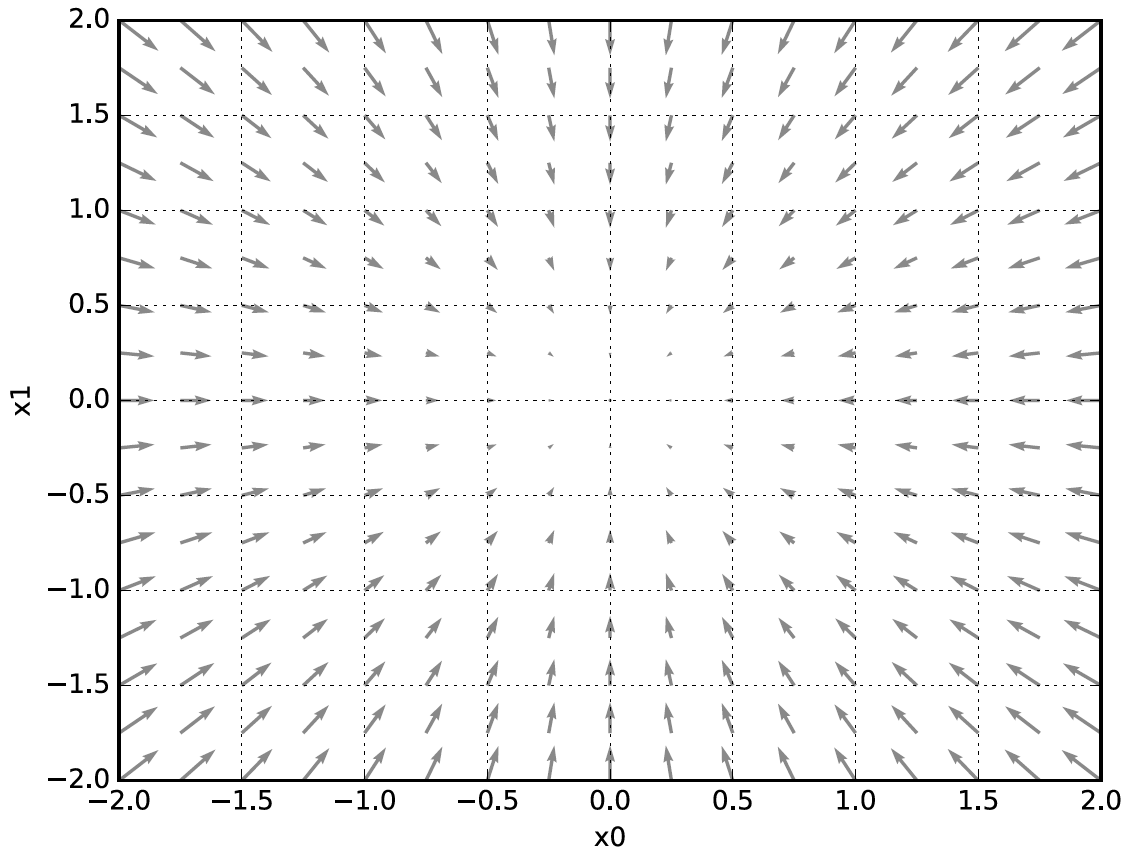

In [61]:
print("기울기는 아래 그림처럼 크기와 방향을 가진 벡터(화살표)로 그려진다.\n"
     "기울기는 함수가 만들어내는 가장 낮은 장소(최솟값)을 향하는 것처럼 보임\n"
     "또한 중점에서 멀어질수록 벡터의 크기가 커지는 것을 알 수 있음")
fig("fig 4-9", w = 400)

In [62]:
print("엄밀히 따지자면 기울기가 가리키는 쪽은 각 장소에서 함수의 출력 값을 가장 크게 줄이는 방향\n"
     "== 미분을 했을 때 미분계수가 음수냐, 양수냐에 따라서 탐색의 방향이 달라지기 때문")

엄밀히 따지자면 기울기가 가리키는 쪽은 각 장소에서 함수의 출력 값을 가장 크게 줄이는 방향
== 미분을 했을 때 미분계수가 음수냐, 양수냐에 따라서 탐색의 방향이 달라지기 때문


### 경사법(경사하강법)

In [63]:
print("신경망은 학습과정에서 최적의 매개변수, 즉, 손실함수가 최솟값이 되는 매개변수를 찾아야 함.\n"
     "매개변수의 공간은 너무나 광범위해서 어디가 최솟값인지, 정말 최솟값인지 판단하기 어려움\n"
     "때문에 기울기를 잘 이용해서(기울기의 방향을 통해서) 함수의 최솟값 또는 가능한 한 작은 값을 찾는 방법이\n"
     "경사하강법이다.")

신경망은 학습과정에서 최적의 매개변수, 즉, 손실함수가 최솟값이 되는 매개변수를 찾아야 함.
매개변수의 공간은 너무나 광범위해서 어디가 최솟값인지, 정말 최솟값인지 판단하기 어려움
때문에 기울기를 잘 이용해서(기울기의 방향을 통해서) 함수의 최솟값 또는 가능한 한 작은 값을 찾는 방법이
경사하강법이다.


경사하강법의 수식
여기서 n(에타)은 탐색(학습)하는 정도를 나타냄 == learning_rate == step_size
4.7 식에서는 변수가 2개인 경우이지만, 변수의 수가 늘어도 같은 식(편미분)을 통해 탐색하게됨
learning_rate는 미리 설정해야 하고, 너무 크거나 너무 작으면 최적의 장소를 탐색하는 데 적절치 않게 된다.


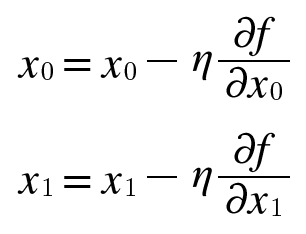

In [64]:
print("경사하강법의 수식\n"
     "여기서 n(에타)은 탐색(학습)하는 정도를 나타냄 == learning_rate == step_size\n"
     "4.7 식에서는 변수가 2개인 경우이지만, 변수의 수가 늘어도 같은 식(편미분)을 통해 탐색하게됨\n"
     "learning_rate는 미리 설정해야 하고, 너무 크거나 너무 작으면 최적의 장소를 탐색하는 데 적절치 않게 된다.")
fig("e 4.7")

In [65]:
def gradient_descent(f, init_x, lr = 0.01, step_num=100): #f는 최적화하려는 함수, init_x는 초깃값, lr은 learning_rate, step_num은 반복횟수
    x = init_x
    
    for i in range(step_num): # 이 for문을 step_num만큼 반복하는데
        grad = numerical_gradient(f, x) # 위에서 만든 함수로 기울기를 구하고
        x -= lr * grad # 정해놓은 lr에 기울기를 곱해서 초깃값에서 빼줌()
    return x

In [66]:
def function_2(x):
    return x[0] ** 2 + x[1] ** 2

init_x = np.array([-3.0, 4.0])
result = gradient_descent(function_2, init_x = init_x, lr = 0.1, step_num = 100)

print("최종 탐색결과가 {}이므로 (0, 0)에 가까운 결과이기 때문에 경사하강법으로 거의 정확한 결과를 얻은 것".format(result))

최종 탐색결과가 [-6.11110793e-10  8.14814391e-10]이므로 (0, 0)에 가까운 결과이기 때문에 경사하강법으로 거의 정확한 결과를 얻은 것


경사하강법을 통해 최적의 장소를 탐색하는 과정(x_0과 x_1이 0에 가까운 지점)


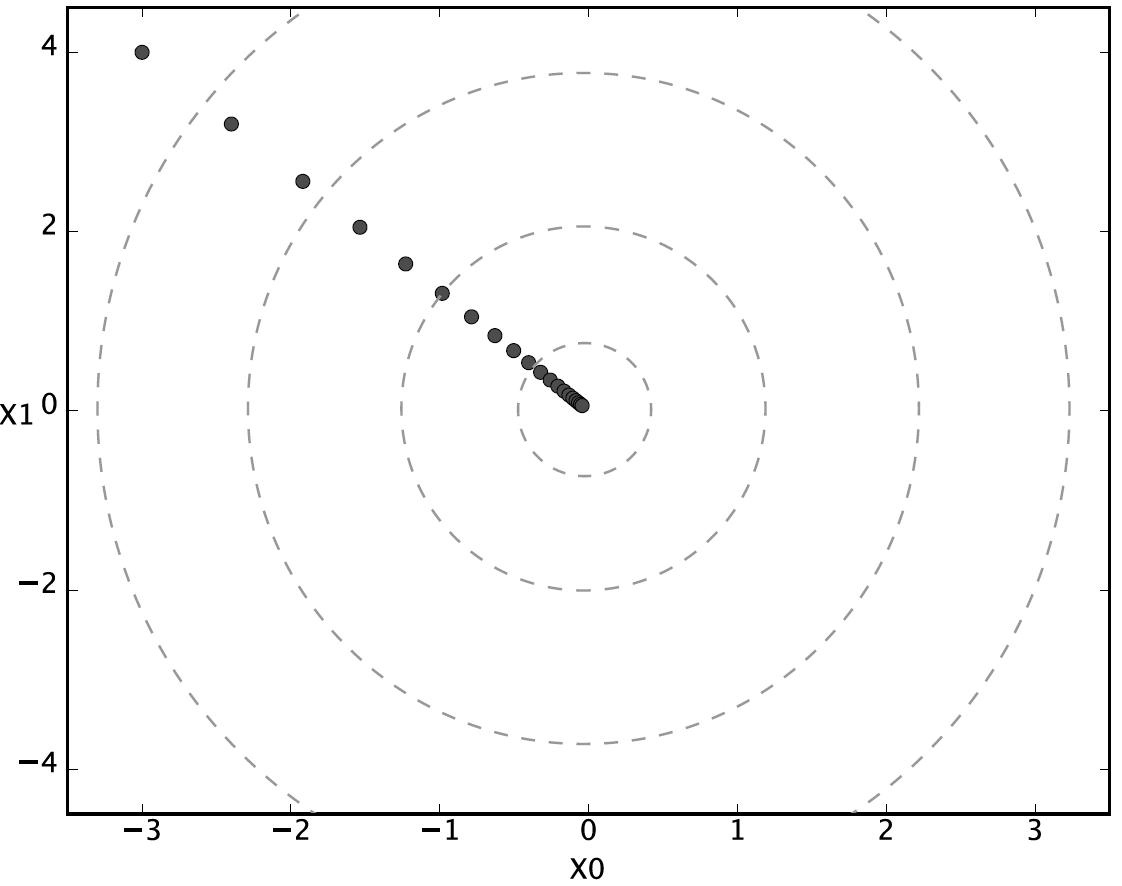

In [67]:
print("경사하강법을 통해 최적의 장소를 탐색하는 과정(x_0과 x_1이 0에 가까운 지점)")
fig("fig 4-10", w = 400)

In [68]:
print("learning_rate를 조정했을 때의 결과 확인")

print("학습률이 너무 클 때(lr = 10.0) -> 탐색의 폭이 너무 커서 왔다갔다만 하다가 학습이 종료된다.")
init_x = np.array([-3.0, 4.0])
print(gradient_descent(function_2, init_x = init_x, lr = 10.0, step_num = 100))


print("학습률이 너무 작을 때(lr = 1e-10) -> 탐색의 폭이 너무 작아서(소극적이어서) 얼마 탐색 못해보고 학습이 종료된다.")
init_x = np.array([-3.0, 4.0])
print(gradient_descent(function_2, init_x = init_x, lr = 1e-10, step_num = 100))



learning_rate를 조정했을 때의 결과 확인
학습률이 너무 클 때(lr = 10.0) -> 탐색의 폭이 너무 커서 왔다갔다만 하다가 학습이 종료된다.
[-2.58983747e+13 -1.29524862e+12]
학습률이 너무 작을 때(lr = 1e-10) -> 탐색의 폭이 너무 작아서(소극적이어서) 얼마 탐색 못해보고 학습이 종료된다.
[-2.99999994  3.99999992]


In [69]:
print("이렇게 사용자가 설정해줘야 하는 파라미터를 hyper parameter(초매개변수)라 칭함 - 통상 여러 lr을 dict로 놓고 파라미터 서치\n"
     "*가중치와 편향같은 매개변수와는 성질이 다름(얘네는 학습과정을 통해 자동으로 획득, 갱신되는 매개변수)")

이렇게 사용자가 설정해줘야 하는 파라미터를 hyper parameter(초매개변수)라 칭함 - 통상 여러 lr을 dict로 놓고 파라미터 서치
*가중치와 편향같은 매개변수와는 성질이 다름(얘네는 학습과정을 통해 자동으로 획득, 갱신되는 매개변수)


### 신경망에서의 기울기 - simplenet부터 다시

In [70]:
print("*탐색의 방향때문이 아닌 가중치 매개변수에 대한 손실함수의 기울기\n\n")
print("가중치가 W, 손실함수가 L, shape가 2 * 3인 신경망이 있다.")

*탐색의 방향때문이 아닌 가중치 매개변수에 대한 손실함수의 기울기


가중치가 W, 손실함수가 L, shape가 2 * 3인 신경망이 있다.


위 신경망의 경사는 $\frac{∂L}{∂W}$로 나타낼 수 있음. 


<!-- $A^{(1)} = ( a^{(1)}_{1 }, a^{(1)}_{2 }, a^{(1)}_{3 })$

$X = (x_1, x_2)$

$B^{(1)} = ( b^{(1)}_{1 }, b^{(1)}_{2 }, b^{(1)}_{3 })$

$W^{(1)} = \begin{pmatrix} w^{(1)}_{11} & a^{(1)}_{21} & a^{(1)}_{31}
\\ w^{(1)}_{12} & a^{(1)}_{22} & a^{(1)}_{32} \end{pmatrix}$ -->

형상을 표현하면 아래와 같음


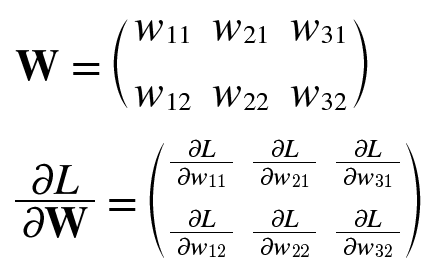

In [71]:
print("형상을 표현하면 아래와 같음")
fig("e 4.8", w = 350)

예를 들어 1행 1번째 원소인 $\frac{∂L}{∂W_{11}}$은 $W_{11}$을 조금 변경했을 때 손실함수 L이 얼마나 변화하는 지를 나타냄

*여기서 중요한 건 $\frac{∂L}{∂W}$의 형상이 W와 같다는 것(shape)

In [72]:
os.pardir

'..'

In [73]:
print("기울기 구하는 코드 구현")

import sys, os
sys.path.append(os.pardir)
from other.common.functions import softmax, cross_entropy_error
from other.common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2, 3) # 정규분포로 초기화
        
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        return loss

기울기 구하는 코드 구현


In [74]:
net = simpleNet() # 위 클래스
print("가중치 매개변수: " +str(net.W)) # 가중치 매개변수

x = np.array([0.6, 0.9])
p = net.predict(x)
print("predict: "+ str(p))
print("argmax(p): " + str(np.argmax(p)))

t = np.array([0, 0, 1]) # 정답 레이블
print("loss: " + str(net.loss(x, t)))

가중치 매개변수: [[ 0.70289547 -1.7199631   1.97003561]
 [-0.37565672 -0.26131083  0.10533304]]
predict: [ 0.08364624 -1.2671576   1.2768211 ]
argmax(p): 2
loss: 0.32339421942441604


In [75]:
def f(W):
    return net.loss(x, t)

dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.1316781   0.03410884 -0.16578693]
 [ 0.19751715  0.05116325 -0.2486804 ]]


In [76]:
print("위 2*3 행렬은 각 W가 변화할 때 Loss의 변화를 의미함\n"
     "예를 들어 1,1의 w가 0.049만큼 변할 때 손실함수는 0.049h만큼 증가한다라는 의미, 1, 3은 음수이니까 감소의 의미이며, 그 크기가 1,1보다 큼")

위 2*3 행렬은 각 W가 변화할 때 Loss의 변화를 의미함
예를 들어 1,1의 w가 0.049만큼 변할 때 손실함수는 0.049h만큼 증가한다라는 의미, 1, 3은 음수이니까 감소의 의미이며, 그 크기가 1,1보다 큼


In [77]:
print("참고 - 보통 새 함수를 정의할 때 def f(x): 문법을 썼는데, 간단한 함수라면 lambda를 쓰는 것이 더 편함")

f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)

참고 - 보통 새 함수를 정의할 때 def f(x): 문법을 썼는데, 간단한 함수라면 lambda를 쓰는 것이 더 편함


## 학습 알고리즘 구현하기

신경망 학습의 순서 복습

*전제 : 신경망에는 적응 가능한 가중치, 편향이 있고 이를 훈련데이터에 적응하도록 조정하는 과정을 '학습'이라 표현함. 4단계로 구성

1단계 - 미니배치
- 훈련 데이터 중 일부를 무작위로 가져옴. 이렇게 선별한 데이터를 미니배치라 하고, 미치배치의 손실 함수 값을 줄이는 것이 학습의 목표

2단계 - 기울기 산출
- 미니배치의 손실 함수 값을 줄이기 ㅣ위해 각 가중치 매개변수의 기울기를 구함. 기울기는 손실 함수의 값을 가장 작게만드는 방향을 제시함(음, 양, 크기)

3단계 - 매개변수 갱신
- 가중치 매개변수를 기울기 방향으로 아주 조금 갱신

4단계 - 반복
- 1 ~ 3단계를 반복한다.


### 2층 신경망 클래스 구현하기

In [86]:
print("2층 신경망 클래스 구현하기")

import sys, os
sys.path.append(os.pardir)
from other.common.functions import *
from other.common.gradient import numerical_gradient

class TwoLayerNet:
    #초기화를 수행한다. 인수는 순서대로 입력층의 뉴런수, 은닉층의 뉴런수, 출력층의 뉴런수)
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):#28*28인 이미지는 총 784개의 input, ouput은 10개(0~9레이블)
        #가중치 초기화
        # params = 신경망의 매개변수를 보고나하는 딕셔너리
        self.params = {}
        #params["W1"]은 1번째 층의 가중치, params["b1"]은 1번째 층의 편향
        self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params["b1"] = np.zeros(hidden_size)
        #params["W2"]은 2번째 층의 가중치, params["b2"]은 2번째 층의 편향
        self.params["W2"] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params["b2"] = np.zeros(output_size)
    
    #예측을 수행한다.(인수 x는 이미지 데이터)
    def predict(self, x):
        W1, W2 = self.params["W1"], self.params["W2"]
        b1, b2 = self.params["b1"], self.params["b2"]
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    # 손실 함수의 값을 구한다.(인수 x는 이미지 데이터, t는 정답레이블)
    # x: 입력 데이터, t: 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    # 정확도를 구한다.
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        t = np.argmax(t, axis = 1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        
        return accuracy
    
    # 가중치 매개변수의 기울기를 구한다.
    # x: 입력 데이터, t: 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        #기울기를 보관하는 딕셔너리
        grads = {}
        # grads["W1"]은 1번째 층의 기울기, grads["b1"]은 1번째 층 편향의 기울기(편미분이니깐 2개)
        grads["W1"] = numerical_gradient(loss_W, self.params["W1"])
        grads["b1"] = numerical_gradient(loss_W, self.params["b1"])
        # grads["W2"]은 2번째 층의 기울기, grads["b2"]은 2번째 층 편향의 기울기(편미분이니깐 2개)
        grads["W2"] = numerical_gradient(loss_W, self.params["W2"])
        grads["b2"] = numerical_gradient(loss_W, self.params["b2"])
    
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

2층 신경망 클래스 구현하기


In [87]:
print("params에 어떤 변수가 저장되는지 확인 - 신경망에 필요한 매개변수가 모두 저장된다.")
net = TwoLayerNet(input_size = 784, hidden_size = 100, output_size = 10)
print(net.params["W1"].shape)
print(net.params["b1"].shape)
print(net.params["W2"].shape)
print(net.params["b2"].shape)

params에 어떤 변수가 저장되는지 확인 - 신경망에 필요한 매개변수가 모두 저장된다.
(784, 100)
(100,)
(100, 10)
(10,)


In [88]:
x = np.random.rand(100, 784) # 더미 입력데이터(100장 분량)
y = net.predict(x)
y

array([[0.10060107, 0.09804471, 0.09337275, 0.09992277, 0.10537222,
        0.10372292, 0.10122974, 0.09298563, 0.10649103, 0.09825717],
       [0.10029305, 0.09740854, 0.09342142, 0.0997259 , 0.10499437,
        0.10393617, 0.10157147, 0.09372242, 0.10668302, 0.09824365],
       [0.10081762, 0.09728536, 0.09364134, 0.09986357, 0.10510942,
        0.10369871, 0.10152591, 0.09339947, 0.10642062, 0.09823797],
       [0.10013686, 0.09793044, 0.09369347, 0.09990554, 0.1053059 ,
        0.10352641, 0.10125923, 0.09342499, 0.1067002 , 0.09811697],
       [0.10047042, 0.09751987, 0.09356619, 0.09951508, 0.10528803,
        0.10412455, 0.1014712 , 0.09351407, 0.10646326, 0.09806735],
       [0.10050992, 0.09789261, 0.09348415, 0.10010198, 0.10466036,
        0.10391155, 0.10136658, 0.09301839, 0.1066001 , 0.09845436],
       [0.10061048, 0.09778142, 0.09343471, 0.09944236, 0.10528209,
        0.10367688, 0.10125033, 0.09369134, 0.10655063, 0.09827977],
       [0.10010725, 0.0978739 , 0.0935395

In [90]:
print("numerical_gradient() method를 활용한 기울기 계산을 하면 grads 변수에 기울기 데이터가 저장됨")

t =  np.random.rand(100, 10) # 100장 분량의 더미 정답 레이블

grads = net.gradient(x, t)

print(grads["W1"].shape)
print(grads["b1"].shape)
print(grads["W2"].shape)
print(grads["b2"].shape)

numerical_gradient() method를 활용한 기울기 계산을 하면 grads 변수에 기울기 데이터가 저장됨
(784, 100)
(100,)
(100, 10)
(10,)


### 미니배치 학습 구현하기

In [98]:
print("훈련 데이터 중 일부를 무작위로 꺼내고(미니배치), 그 미니배치에 대해서 경사하강법으로 매개변수를 갱신하는 것")
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정

from other.dataset.mnist import load_mnist
from other.ch04.two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label = True)

train_loss_list = []

# 하이퍼 파라미터
iters_num = 10000 # 반복횟수
train_size = x_train.shape[0]
batch_size = 100 # 미니배치 크기
learning_rate = 0.1
network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
#    grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch) # 성능 개선 version
    
    # 매개변수 갱신
    for key in ("W1", "b1", "W2", "b2"):
        network.params[key] -= learning_rate * grad[key]
        
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 미니배치 크기를 100으로 했기 때문에 매번 60,000개의 훈련 데이터에서 임의로 100개의 데이터를 샘플링하고,
    # 100개의 미니배치를 대상으로 경사하강법을 수행하여 매개변수를 갱신함
    # 갱신횟수를 10,000번으로 설정했기 때문에 100번의 미니배치 * 10,000회 반복

훈련 데이터 중 일부를 무작위로 꺼내고(미니배치), 그 미니배치에 대해서 경사하강법으로 매개변수를 갱신하는 것


In [99]:
train_loss_list

[2.2936925247562625,
 2.297202424487926,
 2.293136416124208,
 2.2975421687226145,
 2.271541633809076,
 2.283856935223497,
 2.267464199076339,
 2.29650408876734,
 2.299772044965029,
 2.295234038060742,
 2.2848216726552444,
 2.2847519008976573,
 2.30474547934229,
 2.3037923728155505,
 2.2905386345978638,
 2.284358278937318,
 2.3013665218576573,
 2.2916688692460516,
 2.2955813232682103,
 2.2870286798782153,
 2.2847716155621343,
 2.291591066016911,
 2.2942059338558187,
 2.2812911920368406,
 2.2497638440519094,
 2.291754025547649,
 2.311289880096022,
 2.2909397324710854,
 2.2579491873167146,
 2.2594057283862834,
 2.2917518966278285,
 2.284496845293228,
 2.2939364006298946,
 2.300538984255672,
 2.299195568093384,
 2.306043603560978,
 2.2920276042919308,
 2.2911329080976413,
 2.277939138195117,
 2.297548945012433,
 2.2957288263896585,
 2.278555296131434,
 2.29090533986587,
 2.297582454244399,
 2.3007944639733706,
 2.2890299169448296,
 2.2804451187398223,
 2.2963538986538943,
 2.28617955251604

반복횟수가 지속됨에 따라 손실 함수의 값이 줄어들고 있음 -> 학습이 잘되고있다.


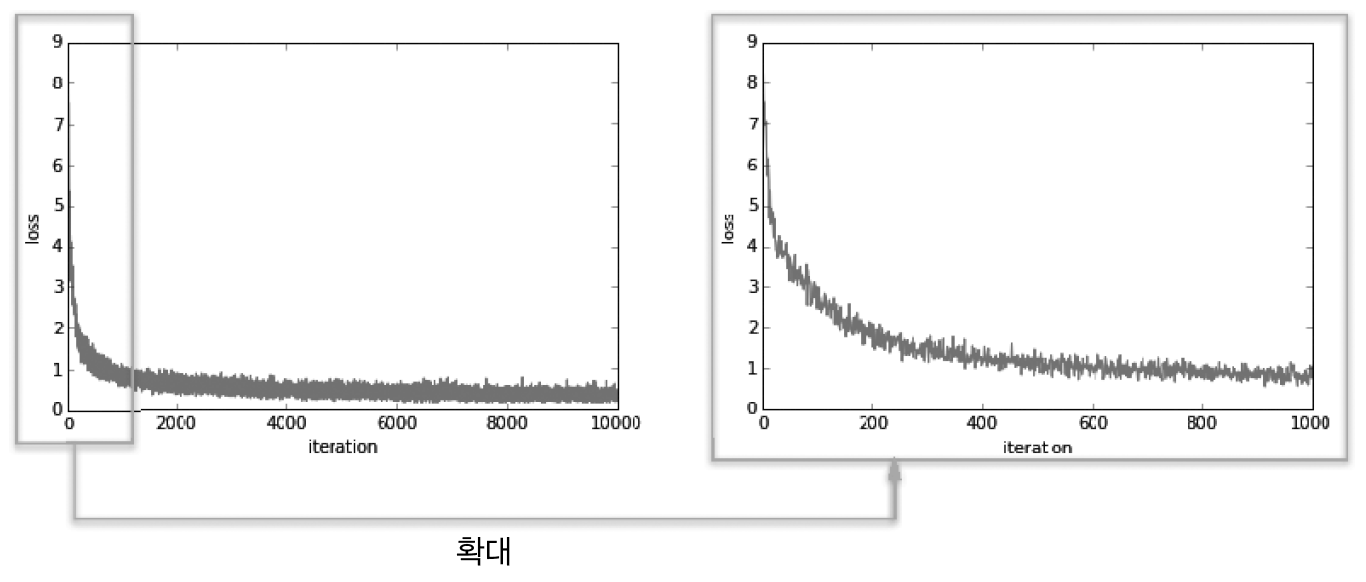

In [100]:
print("반복횟수가 지속됨에 따라 손실 함수의 값이 줄어들고 있음 -> 학습이 잘되고있다.")
fig("fig 4-11", w = 600)

### 시험 데이터로 평가하기

In [101]:
print("1 에폭당(epoch) train set과 test set의 정확도 비교\n"
     "epoch = 학습에서 훈련 데이터를 모두 소진했을 때 1회 카운트. e.g. 1000개의 데이터를 100개의 미니배치로 학습할 경우,\n"
     "경사하강법을 총 10회 반복하면 모든 훈련 데이터를 소진하게 됨. 이 경우 10번의 iter가 끝나면 1 epoch로 카운트")

1 에폭당(epoch) train set과 test set의 정확도 비교
epoch = 학습에서 훈련 데이터를 모두 소진했을 때 1회 카운트. e.g. 1000개의 데이터를 100개의 미니배치로 학습할 경우,
경사하강법을 총 10회 반복하면 모든 훈련 데이터를 소진하게 됨. 이 경우 10번의 iter가 끝나면 1 epoch로 카운트


In [107]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from other.dataset.mnist import load_mnist
from other.ch04.two_layer_net import TwoLayerNet

# from dataset.mnist import load_mnist
# from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.10218333333333333, 0.101
train acc, test acc | 0.7854833333333333, 0.7897
train acc, test acc | 0.8783333333333333, 0.8801
train acc, test acc | 0.8975333333333333, 0.9005
train acc, test acc | 0.9084666666666666, 0.9099
train acc, test acc | 0.9143333333333333, 0.918
train acc, test acc | 0.9195333333333333, 0.921
train acc, test acc | 0.9232166666666667, 0.9259
train acc, test acc | 0.9281166666666667, 0.9297
train acc, test acc | 0.93115, 0.9327
train acc, test acc | 0.93425, 0.9362
train acc, test acc | 0.9366833333333333, 0.9379
train acc, test acc | 0.9387, 0.9383
train acc, test acc | 0.9415, 0.9433
train acc, test acc | 0.9433, 0.9447
train acc, test acc | 0.9455333333333333, 0.9458
train acc, test acc | 0.9475166666666667, 0.9484


훈련 데이터와 시험 데이터에 대한 정확도 추이


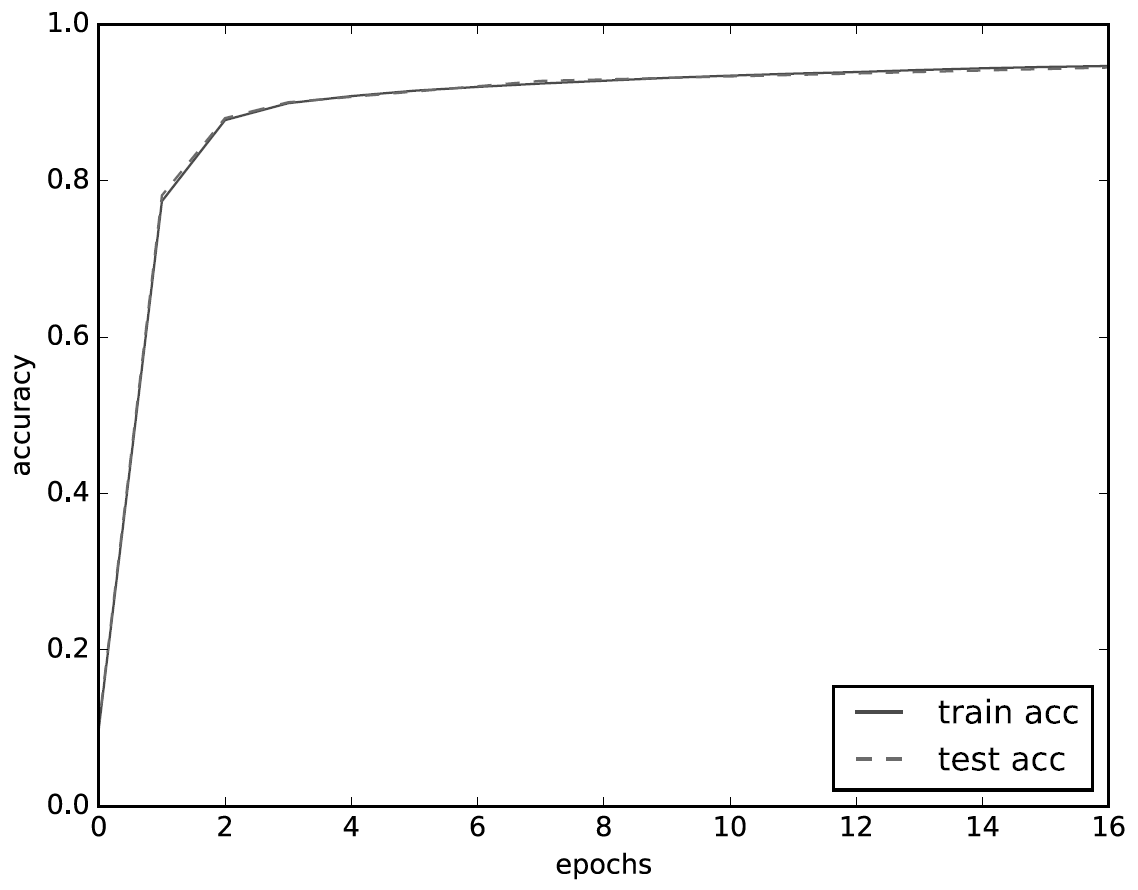

In [109]:
print("훈련 데이터와 시험 데이터에 대한 정확도 추이")
fig("fig 4-12", w = 500)

이번 장에서는 신경망 학습에 대하여 공부함

1) 가장 먼저 신경망이 학습을 수행할 수 있도록 손실 함수(loss function) 지표를 도입했고, 이 손실 함수의 값이 가장 작아지는 가중치 매개변수 값을 찾아내는 것이 신경망 학습의 목표

2) 또한 가능한 한 작은 손실 함수의 값을 찾는 방법으로 경사하강법을 소개함(함수의 기울기)

## 정리

# 밑으로 다 삭제

In [ ]:
print("공통점: \n"
      "입력이 아무리 커도, 아무리 작아도 출력은 0에서 1 사이\n"
     "둘 다 비선형 함수(직선이 아니라는 의미)")

In [ ]:
print("신경망에서는 선형함수를 사용하면 안됨. 선형함수를 이용하면 신경망의 층을 깊게하는 의미가 없어지기 때문\n"
     "활성화함수 h(x) = cx를 3개의 층으로 반복사용한 3층 네트워크를 예로 들어보면,\n"
     "y(x) = h(h(h(x)))가 되고, y(x) = c * c * c * x이며, y = ax형태로 나타내면 y = c^3x가 됨 - > SQL로 치면 동일한 필터를 세 번 사용한 것, 즉 선형")

In [ ]:
#선형이라 함은 f(x) = ax + b 처럼 입력된 값의 상수배만큼 변하는 함수를 선형함수라 표현함
#비선형은 직선 1개로 그릴 수 없는 함수ㅇ

### ReLU 함수

In [ ]:
print("ReLU 함수는 입력이 0을 넘으면 그 입력을 그대로 출력하고, 0이하이면 0을 출력하는 함수")
fig("fig 3-9", w = 500)

In [ ]:
fig("e 3.7", w = 300)

In [ ]:
def relu(x):
  return np.maximum(0, x) #전체 행의 각각의 열 내에서 가장 큰 값 -> 0을 넘으면 그 값을, 0이면 0을

In [ ]:
np.maximum?

In [ ]:
np.maximum(0, 5)

In [ ]:
# # x = np.array([[1,2,3]])
# x_np_arr = np.array([[1,2,3], [4,5,6], [7,8,9]])
# x_arr = ([1,2,3], [4,5,6])
# print(x_np_arr)
# print(x_arr)
# # pd.DataFrame(x)

In [ ]:
# relu(x_np_arr)
# relu(x_arr)

## 다차원 배열의 계산

In [ ]:
### 다차원 배열

In [ ]:
print("다차원 배열도 결론적으로 '숫자의 집합'. 숫자가 1차원으로 길게 늘어져있다, 직사각형이다, 3차원 배열이다 하는 것 보두 다차원 배열이라 표현함")

In [ ]:
A = np.array([1, 2, 3, 4])
print("A는 1차원 배열 ")
print(A)
print(A.shape) # A.shape는 튜플을 반환함
print(A.shape[0]) # 1차원이기 때문에 인덱스를 주면 shape는 4가 나옴(4,0) shape의 1번째니깐

In [ ]:
B = np.array([[1, 2], [3, 4], [5, 6]])
print("B는 1차원 배열 ")
print("B의 구성: "+str(B))
print("B의 차원: "+str(np.ndim(B)))
print(("B의 shape: "+str(B.shape))) # A.shape는 튜플을 반환함
print(B.shape[0]) # (3,2) shape의 0번째니깐 3
pd.DataFrame(B)

In [ ]:
fig("fig 3-10", w = 300)
#e 2.1 그림에서 theta를 -b로 치환 후 좌변으로 옮긴 것

### 행렬의 곱

In [ ]:
fig("fig 3-11", w = 400)

In [ ]:
fig("fig 3-12", w = 400)

In [ ]:
#2차원 array간의 행렬곱
A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])
print("A.shape: " +str(A.shape))
print("B.shape: " +str(B.shape))

print("A dot B: " +str(np.dot(A, B)))
print("A * B : " +str(A * B))
#dot = 행렬의 곱
# A * B = 스칼라간의 곱(대응되는 애들 끼리)

In [ ]:
#1차원 array간의 행렬곱 - 1차원에서의 행렬곱은 스칼라값(대응곱의 합계)을 반환한다. 
A = np.array([1, 2, 3, 4])
B = np.array([5, 6, 7, 8])

print("A dot B: " +str(np.dot(A, B)))
print("A * B: " +str(A * B))

In [ ]:
# (m * k)행렬 * (k * n)행렬 
A = np.array([[1, 2, 3], [4, 5, 6]])
B = np.array([[1, 2],[3, 4], [5, 6]])
print("A dot B: " +str(np.dot(A, B)))
A*B
#행렬곱은 가능하나 스칼라곱은 불가하다.
#ValueError: operands could not be broadcast together with shapes (2,3) (3,2) 

In [ ]:
# (m * k)행렬 * k행렬 = 2차원이상 행렬 * 1차원 행렬
A = np.array([[1, 2], [3, 4], [5,6]])
B = np.array([7,8])
print("A dot B: " +str(np.dot(A, B)))
print("A dot B shape: " +str(np.dot(A, B).shape) + " -> shape를 3, 1이 아니라 (3, )으로 뱉어준다")
print("A * B: " +str(A * B))

In [ ]:
fig("fig 3-13", w = 400)

## 신경망에서의 행렬 곱

In [ ]:
fig("fig 3-14", w = 500)

In [ ]:
X = np.array([1, 2])
W = np.array([[1, 3, 5], [2, 4, 6]])
Y = np.dot(X, W)
print(X.shape)
print(W.shape)
print(Y)
print(Y.shape)
print(X * W)

## 3층 신경망 구현하기

In [ ]:
print("2개의 입력층, 3개의 1차 은닉층, 2개의 2차 은닉층, 2개의 출력층")
fig("fig 3-15", w = 500)

In [ ]:
print("표기법")
fig("fig 3-16", w = 500)

### 표기법 예시
$W^{(1)}_{1 2}$ : 앞 층의 2번째 뉴런(x$_2$)에서 다음 층의 1번째 뉴런(a$^{(1)}_{1}$)으로 향하는 1층의 가중치라는 뜻이며,
가중치 오른쪽 아래의 인덱스 번호는 '다음 층 뉴런의 번호, 앞 층 뉴런의 번호' 순으로 적는다.

### 각 층의 신호 전달 구현하기

In [ ]:
fig("fig 3-17", w = 500)

In [ ]:
Latex("$s_5$")

In [21]:
Latex("$a^{(1)}_{1 2}$")

<IPython.core.display.Latex object>

In [ ]:
print("* 편향 뉴런이 추가되었고, 편향 뉴런은 상수이기 때문에 자신이 속한 층의 위치(1)과 다음 층의 어디로 가는지만 표기됨")
print("첫 번째 은닉층의 첫 번째 뉴런인 ")
Latex("$a^{(1)}_{1 2}$은 가중치를 곱한 신호 두 개와 편향을 합해서 다음과 같이 계산함")

In [ ]:
fig("e 3.8", w = 400)

In [ ]:
print("행렬의 곱을 이용하면 이를 좀 더 간단하게 표현할 수 있음")
fig("e 3.9", w = 400)

In [ ]:
print("이 때 각 행렬은 아래와 같다")

$A^{(1)} = ( a^{(1)}_{1 }, a^{(1)}_{2 }, a^{(1)}_{3 })$

$X = (x_1, x_2)$

$B^{(1)} = ( b^{(1)}_{1 }, b^{(1)}_{2 }, b^{(1)}_{3 })$

$W^{(1)} = \begin{pmatrix} w^{(1)}_{11} & a^{(1)}_{21} & a^{(1)}_{31}
\\ w^{(1)}_{12} & a^{(1)}_{22} & a^{(1)}_{32} \end{pmatrix}$

In [ ]:
print("다차원 array를 활용하여 식 3.9를 구현")

X = np.array([1.0, 0.5])
W1 = np.array([[0.1, 0.3, 0.5], [0.2, 0.4, 0.6]])
B1 = np.array([0.1, 0.2, 0.3])

print(W1.shape)
print(X.shape)
print(B1.shape)
A1 = np.dot(X, W1) + B1

In [ ]:
print("1층의 활성화 함수 처리과정 살펴보기")
print("입력층에서 1층으로의 신호전달 과정을 보여준다.")
print("은닉층에서 가중치의 합을 a로 표기하고, 활성화 함수 h()로 변환된 신호를 z로 표기한다.")
fig("fig 3-18", w = 500)

In [ ]:
print("h(a)로 simoid함수를 사용할 경우")
Z1 = sigmoid(A1)
print("A1: " +str(A1))
print("sigmoid(A1) = Z1: " + str(Z1))

In [ ]:
print("1층(첫 번째 은닉층)에서 2층으로(2 번째은닉층) 가는 활성화 함수 처리과정 살펴보기")
print("1층에서 2층으로의 신호전달 과정을 보여준다.")
print("1층 가중치의 합을 a로 표기하고, 활성화 함수 h()로 변환된 신호를 z로 표기한다.")
fig("fig 3-19", w = 500)

In [ ]:
print("1층 -> 2층 전달 과정\n -> 1층의 출력 Z1이 2층에 입력된다는 점 외에는 다른 게 없다.")

W2 = np.array([[0.1, 0.4], [0.2, 0.5], [0.3, 0.6]])
B2 = np.array([0.1, 0.2])

print(W2.shape)
print(B2.shape)
A2 = np.dot(Z1, W2) + B2
Z2 = sigmoid(A2)

In [ ]:
print("2층에서 출력층으로 신호 전달")
print("활성화 함수만 h()에서 시그마()로 변함")
fig("fig 3-20", w = 500)

In [ ]:
def identity_function(x):
  return x
W3 = np.array([[0.1, 0.3], [0.2, 0.4]])
B3 = np.array([0.1, 0.2])

A3 = np.dot(Z2, W3) + B3
Y = identity_function(A3) # OR Y = A3 -> identity_function 자체가 항등함수(f(x) = x)라서 이렇게 해도 됨

In [ ]:
print("일반적으로 회귀에는 출력층의 활성화 함수에 항등 함수를,\n이항분류에는 시그모이드 함수를,\n다중 클래스 분류에는 소프트맥수를 사용하는 것이 일반적이다.\n"
     "회귀는 출력값을 그대로 사용해야하는 점\n"
     "이항분류는 1개의 클래스를 기준으로 임계치가 넘는지 안넘는지만 보면 되는 점\n"
     "다중 클래스는 여러 클래스 중 가장 큰 값을 예측값으로 봐야하는 점 때문?")

In [ ]:
print("구현 정리 - 신경망 구현 표현의 관례상 가중치만 대문자로, 나머지는 모두 소문자로 작성")

def init_network():
  network = {}
  network['W1'] = np.array([[0.1, 0.3, 0.5], [0.2, 0.4, 0.6]])
  network['b1'] = np.array([0.1, 0.2, 0.3])
  network['W2'] = np.array([[0.1, 0.4], [0.2, 0.5], [0.3, 0.6]])
  network['b2'] = np.array([0.1, 0.2])
  network['W3'] = np.array([[0.1, 0.3], [0.2, 0.4]])
  network['b3'] = np.array([0.1, 0.2])
  
  return network

def forward(network, x):
  W1, W2, W3 = network['W1'], network['W2'], network['W3']
  b1, b2, b3 = network['b1'], network['b2'], network['b3']
  
  a1 = np.dot(x, W1) + b1 # 입력층 -> 1차 은닉층 가중치 계산 결괏값
  z1 = sigmoid(a1) # 1차 은닉층 가중치 계산 결괏값에 대한 활성화함수(sigmoid로 적용)
  a2 = np.dot(z1, W2) + b2 # 1차 은닉층 활성화 결괏값(z1)을 사용한 2차 은닉층 가중치 계산 결괏값
  z2 = sigmoid(a2) # 2차 은닉층 가중치 계산 결괏값에 대한 활성화 함수(sigmoid로 적용)
  a3 = np.dot(z2, W3) + b3 # 2차 은닉층 활성화 결괏값(z2)을 사용한 출력층 가중치 계산 결괏값
  y = identity_function(a3) # 출력층 가중치 계산 결괏값에 대한 활성화(항등)함수 
  
  return y # 항등함수이기 때문에 y = a3 출력

network = init_network()
x = np.array([1.0, 0.5])
y = forward(network, x)
print(y)

In [ ]:
print("위 코드에서 init_network 함수는 가중치와 편향을 초기화하고 이들을 dict 변수인 network에 저장 -> network에 각 층에 필요한 매개변수(가중치와 편향)를 저장한다는 의미")
print("foward 함수는 신호가 순방향(입력 -> 출력 방향)으로 전달됨을 알리기 위함")

## 출력층 설계하기

In [ ]:
print("신경망은 분류, 회귀 모두에 이용할 수 있음. 그러나 앞서 언급한대로 문제의 정의에 따라 출력층 활성화 함수를 다르게 사용해야함")

### 항등 함수와 소프트맥스 함수 구현하기

In [ ]:
print("항등함수는 입력을 그대로 출력하는 함수")

fig("fig 3-21")

In [ ]:
print("소프트맥스 함수는 최저 출력 0, 최대 출력 1을 갖게 만들어주는 함수")
print("n은 출력층의 뉴런수, y_k는 그 중 k 번째 출력을 의미함")
fig("e 3.10")

In [ ]:
print("소프트맥스 함수의 출력은 모든 입력 신호로부터 화살표를 받는다.(출력층의 모든 뉴런이 입력 신호에서 영향을 받는다.)")
fig("fig 3-22")

In [ ]:
a = np.array([0.3, 2.9, 4.0]) #입력
exp_a = np.exp(a) # 수식에 근거 입력값을 모두 지수함수 형태로 변경
print("exp(a): " + str(exp_a))

sum_exp_a = np.sum(exp_a)
print(sum_exp_a) # 수식에 근거 exp_a의 합계 산출

y = exp_a / sum_exp_a

print("출력층의 활성화함수 exp()로 인해 y값은: " + str(y)) #세 출력값의 합계는 1


### 소프트맥스 함수 구현시 주의점

In [ ]:
print("소프트맥스 함수에서 자연로그 e를 사용하는데, e^ak 제곱이 되면 소숫점이 수십개가 되고 이를 연산하면 오버플로우가 발생할 수 있음.\n"
      "따라서 이를 방지하기 위해 입력신호의 최댓값에 로그를 취한 상수 C를 소프트맥스 함수의 분자, 분모에 더해주어 연산이 될 수 있게 처리함")
fig("e 3.11", w = 500)

In [ ]:
a = np.array([1010, 1000, 990]) #입력신호의 초깃값
np.exp(a) / np.sum(np.exp(a)) # 소프트 함수 계산 -> overflow 오류가 뜨면서 계산이 제대로 되지 않는다.

In [ ]:
c = np.max(a) #초기 입력값 array에서 최댓값을 c에 할당한다
a - c #그리고 그 최댓값을 모든 원소에서 빼준다.(작은 숫자로 만들어준다는 것이고, 분자 분모 모두에 적용할 것이기 때문에 영향없음)

In [ ]:
np.exp(a-c) / np.sum(np.exp(a-c)) # 숫자를 작게 만들어줬기 때문에 연산이 정상적으로 가능하다.

In [ ]:
print("이를 바탕으로 소프트맥스 함수 구현 코드를 다시 생성")

def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a-c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

### 소프트맥스 함수의 특징

In [ ]:
print("소프트맥스 함수를 사용하면 신경망의 출력은 아래와 같이 계산할 수 있다.\n"
     "최종 출력값 3개의 합이 1이라는 점이 소프트맥스 함수의 중요한 성질이다.\n"
     "합이 1이라는 점이 소프트맥스 함수의 출력값을 일종의 확률로 해석할 수 있기 때문이다.(*개인적으로는 확률보다는 MinMaxScaler와 같은 장치로 이해함)\n"
     "*y = exp(x) 자체가 단조증가(a >= b이면 f(a) >= f(b)가 항상 성립)하기 때문에 스케일링을 해도 대소관계가 변하지는 않음")

a = np.array([0.3, 2.9, 4.0])
y = softmax(a)
print("상수 C를 고려한 소프트맥스 함수의 출력값 y: " + str(y))
print("출력값 y의 합계: " + str(np.sum(y)))

In [ ]:
print("위와 같은 성질 때문에(단조증가) 그리고 리소스 낭비를 방지하고자 일반적으로 추론(실제 분류 단계)에서는 소프트 맥스 함수를 생략한다.\n"
     "그러나 학습 과정에서는 소프트맥스 함수를 사용함.")

### 출력층의 뉴런 수 정하기

In [ ]:
print("출력층의 뉴런 수는 문제에 따라 적절히 정의 -> 일반적으로 분류하고 싶은 클래스 수로 설정하는 것이 일반적")

In [ ]:
print("분류해야할 클래스가 10개면 출력층도 10개로 설정함")
fig("fig 3-23", img_type = ".jpg", w = 500)

## 손글씨 숫자 인식

### MNIST 데이터셋(,손글씨 숫자 이미지 집합)

In [ ]:
print("손글씨 이미지 데이터셋\n"
     "28 * 28 크기의 회색조 이미지(1채널)이며, 각 픽셀은 0에서 255까지의 값을 취함\n"
     "또한 이미지에는 그 이미지가 어떤 숫자를 의미하는지 레이블이 붙어있음")
fig("fig 3-24", w = 500)

In [ ]:
# !pip install python-mnist
!pip install pillow

In [ ]:
# !pip install python-mnist
!pip install pillow

# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from other.dataset.mnist import load_mnist
from PIL import Image


def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    pil_img.show()

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False, one_hot_label=False) #flatten = 배열의 평탄화, normalize = 픽셀 값을 0~255로 할 것인지(False) 0~1로 정규화 할 것인지(True),
#one_hot_label = 레이블을 원핫인코딩으로 표현할 것인지(True), 실제 레이블로 표현할 것인지(False)

img = x_train[0]
label = t_train[0]
print(label)  # 5

print(img.shape)  # (784,)
img = img.reshape(28, 28)  # 형상을 원래 이미지의 크기로 변형 -> flatten = True로 되어있으면 1차원 array로 저장함. shape가 [n, ]이라는 말. 그래서 변형해주는 것임
print(img.shape)  # (28, 28)

img_show(img)

In [ ]:
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

In [ ]:
x_train

In [ ]:
t_train

In [ ]:
print("mnist 이미지 예")
fig("fig 3-24", w = 500)

### 신경망의 추론 처리

In [ ]:
print("입력층 뉴런은 784개 (28 * 28 = 784)")
print("출력층 뉴런은 10개 (0 ~ 9 갯수)")
print("은닉층은 총 2개이며, 1차 은닉층에는 50개의 뉴런, 2차 은닉층에는 100개의 뉴런 배치(임의로 정함)")


def get_data():
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, flatten = True, one_hot_label = False)#flatten = 배열의 평탄화(1차원), normalize = 픽셀 값을 0~255로 할 것인지(False) 0~1로 정규화 할 것인지(True),
#one_hot_label = 레이블을 원핫인코딩으로 표현할 것인지(True), 실제 레이블로 표현할 것인지(False)
    return x_test, t_test
# 학습된 가중치 매개변수를 읽는 과정. 가중치와 편향 매개변수가 dict로 저장되어 있음    
def init_network():
    with open("D:\공유 드라이브\Predictive Marketing\Team\개인\항민\deep_learning_from_the_basic/other/ch03/sample_weight.pkl", "rb") as f: #windows
#     with open("/Volumes/GoogleDrive/내 드라이브/local_notebook/deep_learning_from_the_basic/other/ch03/sample_weight.pkl", "rb") as f: #mac
        network = pickle.load(f)
    return network

def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)
    return y

In [ ]:
print(os.getcwd())

In [ ]:
x, t = get_data() # mnist 데이터셋에서 데이터 가져옴
network = init_network() #pickle에 있는 dict 가져옴

accuracy_cnt = 0 #시작은 0
for i in range(len(x)): # for문을 0 <= i <= 9999 까지 돌리는데,
    y = predict(network, x[i]) # 1장씩 꺼내서 predict 함수로 분류한다. 이 때 [0.1, 0.05, 0.5 ... ...] 같은 배열이 반환되고, (아래 셀 참고)
    p = np.argmax(y) # 확률이 가장 높은 원소의 인덱스(argmax = array내에서 가장 큰 값)를 할당함(인덱스라고 표현은 했지만 이게 바로 예측결과임) e.g. np.argmax(predict(network, x[0]))의 결괏값은 7
    if p == t[i]: # np.argmax(y[i])가 같은 sequence의 t[i]와 같으면 accuracy_cnt에 +1(예측값 == 실젯값)
        accuracy_cnt += 1
print("Accuracy:" + str(float(accuracy_cnt) / len(x)))

In [ ]:
predict(network, x[0])

In [ ]:
test = []

for i in range(len(x)): # for문을 0 <= i <= 9999 까지 돌리는데,
    y = predict(network, x[i]) # 1장씩 꺼내서 precit 함수로 분류한다. 이 때 [0.1, 0.05, 0.5 ... ...] 같은 배열이 반환되고, 
    test.append(np.argmax(y)) # 확률이 가장 높은 원소의 인덱스(argmax = array내에서 가장 큰 값)를 할당함(인덱스라고 표현은 했지만 이게 바로 예측결과임) e.g. np.argmax(predict(network, x[0]))의 결괏값은 7

In [ ]:
testdf = pd.DataFrame(test, columns = ["pred"])
testdf

In [ ]:
testdf["actual"] = t
testdf

In [ ]:
print(len(testdf[testdf.pred == testdf.actual]))
print(len(testdf)-len(testdf[testdf.pred == testdf.actual]))
print(len(testdf[testdf.pred == testdf.actual])+(len(testdf)-len(testdf[testdf.pred == testdf.actual])))

In [ ]:
print("예제에서는 단순히 0~255 픽셀을 255로 나눠서 0~1로 정규화했는데, 실제 사례에서는 데이터 분포를 고려해서 다양한 스케일링 방법을 적용함\n"
     "저자는 데이터를 균일하게 분포시키는 백색화(whitening)에 대한 내용도 기술함")

### 배치 처리

In [ ]:
x, _ = get_data()
network = init_network()

W1, W2, W3 = network['W1'], network['W2'], network['W3']
print("x.shape: " + str(x.shape))
print("x[0].shape: " +str(x[0].shape))
print("W1.shape: " + str(W1.shape))
print("W2.shape: " + str(W2.shape))
print("W3.shape: " + str(W3.shape) + "\n")
print("입력데이터와 가중치 매개변수의 형상이 잘 대응된다.(x = n행, 784열, W1 = 784행, 50열, W2 = 50행, 100열, W3 = 100행, 10열")

In [ ]:
print("위 예시와 아래 이미지는 1개의 이미지를 input했을 때의 형상이다.")
fig("fig 3-26", w = 500)

In [ ]:
print("이미지 여러 장(여기서는 100장)을 한꺼번에 입력하는 경우에는\n"
     "x의 형상을 100*784의 형상으로 바꾸어서 한 번에 input하는 것으로 이해하면 된다.\n"
     "이렇게 여러 데이터를 지폐 뭉치처럼 묶는 것을 배치라고 함\n"
     "1) 수치 계산 라이브러리 대부분이 큰 배열을 효율적으로 처리할 수 있도록 최적화되어 있음\n"
     "2) 데이터 하나 하나에 대한 연산을 하지 않기 때문에 병목현상 방지")
fig("fig 3-27", w = 500)

In [ ]:
x, t = get_data()
network = init_network()

batch_size = 100 # 배치크기
accuracy_cnt = 0

for i in range(0, len(x), batch_size):
    x_batch = x[i:i+batch_size] # start 0부터 batch_size 100단위로 끊어서 할당 e.g. x[0:100], x[100:200] 결괏값은 아래 실행결과 참고
    y_batch = predict(network, x_batch) # (100행 * 784열)형태의 array를 한 번에 predict해서 100행 10열 출력
    p = np.argmax(y_batch, axis = 1) # y_batch 행별 결괏값에서 argmax()로 최댓값의 index할당(단, axis=1)
    accuracy_cnt += np.sum(p == t[i:i+batch_size]) # 실젯값(레이블)과 예측값이 같은 경우 해당 갯수만큼 acc_cnt에 더해줌
    
print("Accuracy:" + str(float(accuracy_cnt) / len(x) ))

In [ ]:
pd.DataFrame(y_batch)

In [ ]:
pd.DataFrame(np.argmax(y_batch, axis = 1))

In [ ]:
pd.DataFrame(x[0:100])
#이걸 predict하고 이후 argmax

## 정리

이번 장에서는 신경망의 순전파를 살펴봄

각 층의 뉴런들이 다른 층의 뉴런으로 신호를 전달한다는 점에서 앞 장의 퍼셉트론과 개념은 동일하나,

다음 뉴런으로 넘어갈 때 신호를 변화시키는 활성화 함수에 큰 차이가 있었음.

신경망에서 시그모이드 함수를, 퍼셉트론에서는 계단 함수를 그 예로 들 수 있음.

